# Predicción de Niveles de Riesgo en Denuncias de Violencia Doméstica

Esta notebook tiene como objetivo el entrenamiento de modelos para predecir el nivel de riesgo en denuncias de violencia doméstica.  
Recibe como input 9 archivos `.csv` que se pueden obtener [aquí](https://datos.csjn.gov.ar/group/violencia-domestica).

Finalmente, el modelo seleccionado fue **CatBoost**, ya que obtuvo el mejor AUC y las mejores métricas de performance, observando principalmente el **recall**.

---

## Estructura de la Notebook

1. **Unificación de bases de datos**  

   Se unifican las bases correspondientes a los distintos años en un solo DataFrame consolidado (2017-2023).

2. **Limpieza de datos y generación de variables nuevas**  

   Se procesan los datasets originales y se crean variables derivadas que aporten valor predictivo.

3. **Entrenamiento de un modelo de referencia (Evaluación Preliminar sobre Base Comparativa)**

   Utiliza datos desde 2017 al 2020 como línea base para comparar con un modelo de referencia.

4. **Entrenamiento de CatBoost con variable objetivo multicategórica**  

   Se utiliza la variable original de riesgo con las categorías: *Altísimo, Alto, Medio, Moderado, Bajo, Sin riesgo*.  Utiliza datos desde 2017 al 2023.

5. **Entrenamiento de CatBoost con riesgo binarizado (Altísimo = 1, resto = 0)**

   Utiliza datos desde 2017 al 2023.

6. **Entrenamiento de CatBoost con riesgo binarizado (Altísimo o Alto = 1, resto = 0)**  

   También se visualiza la *feature importance* del modelo y el *interaction score* de una variable.  Utiliza datos desde 2017 al 2023.

7. **Entrenamiento de CatBoost con SMOTE**  

   Se repite el entrenamiento del punto 6, pero aplicando *oversampling* con SMOTE para balancear la clase positiva.  Utiliza datos desde 2017 al 2023.

8. **Comparación con otros algoritmos**  

   Se prueban: Regresión Logística, Árboles de Decisión, Random Forest, XGBoost, LightGBM, Redes Neuronales Multicapa (MLP), CatBoost y Histogram Gradient Boosting.  Utiliza datos desde 2017 al 2023.

9. **Comparación de AUC y métricas**  

    Se compara el AUC de todos los modelos. Además, en cada modelo se analizan las métricas de performance: **recall, f1-score, precision**, y la **matriz de confusión**.

10. **Entrenamiento de CatBoost con riesgo binarizado con nueva variable (Altísimo o Alto = 1, resto = 0)**  

    Se repite el entrenamiento del punto 6, pero utilizando una nueva variable explicativa.

11. **Sección Adicional**  

    Se repite el entrenamiento del punto 10, pero utilizando datos del 2020 al 2023. Esta sección fue solo una prueba para ver si el modelo performaba mejor con los años más recientes. Sin embargo, el modelo con los datos del 2017 al 2023 obtiene la mejor performance.

---


### 1. Unificacion de bases de datos

#### Se importan Librerias

In [1]:
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import numpy as np
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
import time
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV



from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as ltb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint

2025-07-14 01:43:40.592424: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Se importan CSV

In [2]:
denuncias_caract_2023 = pd.read_csv('../data/personas_2023.csv',sep=';') 

denuncias_caract_2022 = pd.read_csv('../data/personas_2022.csv',sep=';')

denuncias_2023 = pd.read_csv('../data/denuncias_2023.csv',sep=';')

denuncias_2022 = pd.read_csv('../data/denuncias_2022.csv',sep=';')

denuncias_2021 = pd.read_csv('../data/denuncias_2021.csv',sep=',')

denuncias_2020 = pd.read_csv('../data/denuncias_2020.csv',sep=';')

denuncias_2019 = pd.read_csv('../data/denuncias_2019.csv',sep=';')

denuncias_2018 = pd.read_csv('../data/denuncias_2018.csv',sep=';')

denuncias_2017 = pd.read_csv('../data/denuncias_2017.csv',sep=';')

In [3]:
# Se revisa cantidad de registros por tabla

print(len(denuncias_2023))
print(len(denuncias_2022))
print(len(denuncias_2021))
print(len(denuncias_2020))
print(len(denuncias_2019))
print(len(denuncias_2018))
print(len(denuncias_2017))

14394
13835
11579
9974
16450
15374
14147


### Se unifican bases de datos

In [4]:
def procesar(denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020, 
             denuncias_2021, denuncias_2022, denuncias_2023, 
             denuncias_caract_2022, denuncias_caract_2023):
    

    """
    Procesa CSV con las denuncias de cada año.

    Parámetros:
    - denuncias_2017 a denuncias_2023: DataFrames con las denuncias de cada año.
    - denuncias_caract_2022, denuncias_caract_2023: DataFrames con características adicionales de los años 2022 y 2023

    Retorna un DataFrame unificado con las denuncias de cada año y las columnas en común
    """

    # Se crea una lista de dataframes
    dataframes = [denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020, 
                  denuncias_2021, denuncias_2022, denuncias_2023, 
                  denuncias_caract_2022, denuncias_caract_2023]
    
    for df in dataframes:
        df.columns = [col.lower() for col in df.columns]

    # Se genera columna de año con el formato correcto
    denuncias_2023['año'] = '2023'
    denuncias_2022['año'] = '2022'
    denuncias_2021['año'] = '2021'
    denuncias_2020['año'] = '2020'
    denuncias_2019['año'] = '2019'
    denuncias_2018['año'] = '2018'
    denuncias_2017['año'] = '2017'
        
    # Seleccionar columnas de las bases de características
    denuncias_caract_2023 = denuncias_caract_2023[['id_datos_abiertos_legajo', 'ingreso', 'denuncia_tercera']]
    denuncias_caract_2022 = denuncias_caract_2022[['id_datos_abiertos_legajo', 'ingreso', 'denuncia_tercera']]
    
    # Merge con las tablas de características
    denuncias_2023 = denuncias_2023.merge(denuncias_caract_2023, on='id_datos_abiertos_legajo', how='left')
    denuncias_2022 = denuncias_2022.merge(denuncias_caract_2022, on='id_datos_abiertos_legajo', how='left')

    # Paso 3: Renombrar las columnas para que coincidan entre las bases de datos
    nuevos_nombres = {
        'viol_ambient': 'v_ambiental',
        'viol_fisica': 'v_fisica',
        'viol_econ': 'v_economica',
        'viol_psicol': 'v_psicologica',
        'viol_sexual': 'v_sexual',
        'viol_simb': 'v_simbolica',
        'viol_social': 'v_social',
        'legajo_tercera': 'denuncia_tercera'
    }
    
    nuevos_nombres2 = {
        'v_ambient': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psicol': 'v_psicologica',
        'v_sexual': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_social': 'v_social',
        'denunciada_nivel instru': 'denunciada_nivel_instru',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres3 = {
        'v_amb': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psic': 'v_psicologica',
        'v_sex': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_soc': 'v_social',
        'evaluacion_riesgo': 'eva_riesgo',
        'condicion_actividad': 'condición_actividad',
        'sexo_genero': 'genero',
        'denunciada_cond_lab': 'denunciada_cond_act',
        'nivel_instru': 'nivel_instruccion',
        'condición_laboral': 'condición_actividad',
        'denunciada_sexo_genero': 'denunciada_sexo',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres4 = {
        'v_amb': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psic': 'v_psicologica',
        'v_sex': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_soc': 'v_social',
        'evaluacion_riesgo': 'eva_riesgo',
        'condicion_actividad': 'condición_actividad',
        'sexo_genero': 'genero',
        'denunciada_cond_lab': 'denunciada_cond_act',
        'nivel_instru': 'nivel_instruccion',
        'condición_laboral': 'condición_actividad',
        'denunciada_sexo_genero': 'denunciada_sexo',
        'sexo': 'genero',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres5 = {'leg_tercera': 'denuncia_tercera',
                       'v_económica':'v_economica'}

    # Renombrar las columnas en cada DataFrame
    denuncias_2017 = denuncias_2017.rename(columns=nuevos_nombres3)
    denuncias_2018 = denuncias_2018.rename(columns=nuevos_nombres3)
    denuncias_2019 = denuncias_2019.rename(columns=nuevos_nombres4)
    denuncias_2020 = denuncias_2020.rename(columns=nuevos_nombres3)
    denuncias_2021 = denuncias_2021.rename(columns=nuevos_nombres)
    denuncias_2023 = denuncias_2023.rename(columns=nuevos_nombres2)
    denuncias_2022 = denuncias_2022.rename(columns=nuevos_nombres5)

    # Seleccionar columnas comunes entre los DataFrames
    columnas_comunes = [
        'año', 'barrio', 'categoria_ocupacional', 'categoria_ocupacional_detalle', 'cohabitan', 
        'comuna', 'condición_actividad', 'denunciada_cond_act', 'denunciada_edad', 'denunciada_nivel_instru', 
        'denunciada_sexo', 'domicilio_provincia', 'edad', 'eva_riesgo', 'frecuencia_episodios', 'genero', 
        'grupo_edad', 'id_datos_abiertos_legajo', 'id_datos_abiertos_persona', 'ingreso', 'localidad_otras_provincias', 
        'mes', 'nacionalidad', 'nivel_instruccion', 'relacion_afectada_denunciada', 'v_ambiental', 'v_economica', 
        'v_fisica', 'v_psicologica', 'v_sexual', 'v_simbolica', 'v_social', 'denuncia_tercera'
    ]
    
    # Filtrar las columnas comunes en cada DataFrame
    denuncias_2017 = denuncias_2017[columnas_comunes]
    denuncias_2018 = denuncias_2018[columnas_comunes]
    denuncias_2019 = denuncias_2019[columnas_comunes]
    denuncias_2020 = denuncias_2020[columnas_comunes]
    denuncias_2021 = denuncias_2021[columnas_comunes]
    denuncias_2022 = denuncias_2022[columnas_comunes]
    denuncias_2023 = denuncias_2023[columnas_comunes]

    # Asegurarse de que las variables numéricas no generen errores
    denuncias_2019['edad'] = pd.to_numeric(denuncias_2019['edad'], errors='coerce')
    denuncias_2019['edad'] = denuncias_2019['edad'].fillna(1000).astype(int)
    
    # Definir el tipo de variables para la base del año 2019
    denuncias_2019 = denuncias_2019.astype({
        'año': 'str', 'barrio': 'str', 'categoria_ocupacional': 'str', 
        'categoria_ocupacional_detalle': 'str', 'cohabitan': 'str', 
        'comuna': 'str', 'condición_actividad': 'str', 'denunciada_cond_act': 'str',
        'denunciada_edad': 'str', 'denunciada_nivel_instru': 'str', 
        'denunciada_sexo': 'str', 'denuncia_tercera': 'str', 
        'domicilio_provincia': 'str', 'edad': 'int64', 'eva_riesgo': 'str', 
        'frecuencia_episodios': 'str', 'genero': 'str', 'grupo_edad': 'str', 
        'id_datos_abiertos_legajo': 'str', 'id_datos_abiertos_persona': 'str', 
        'ingreso': 'str', 'localidad_otras_provincias': 'str', 'mes': 'str', 
        'nacionalidad': 'str', 'nivel_instruccion': 'str', 'relacion_afectada_denunciada': 'str',
        'v_ambiental': 'str', 'v_economica': 'str', 'v_fisica': 'str', 'v_psicologica': 'str', 
        'v_sexual': 'str', 'v_simbolica': 'str', 'v_social': 'str'
    })

    # Concatenar todos los DataFrames
    dataframes = [denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020, 
                  denuncias_2021, denuncias_2022, denuncias_2023]

    df = pd.concat(dataframes, ignore_index=True)

    return df


In [5]:
df=procesar(denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020, 
                               denuncias_2021, denuncias_2022, denuncias_2023, 
                               denuncias_caract_2022, denuncias_caract_2023 
                              )

### 2. Limpieza de datos y generacion de variables nuevas

In [6]:
def estandarizar_nombres_y_nulos(df):
    """
    Estandariza los nombres de columnas y unifica valores nulos en un DataFrame.

    Parámetros:
        df: DataFrame con los datos originales.

    Retorna:
        DataFrame con los nombres de columnas en minúsculas y valores nulos comunes reemplazados por np.nan,
        excluyendo las columnas identificadoras 'id_datos_abiertos_legajo' y 'id_datos_abiertos_persona'.
    """
    # Convertir nombres de columnas a minúsculas
    df.columns = df.columns.str.lower()
    
    # Columnas identificadoras
    columnas_excluir = ['id_datos_abiertos_legajo', 'id_datos_abiertos_persona']
    
    # Valores considerados como nulos
    valores_nulos = ['#NULL!', 'nan', '.', 'SIN DATOS', 'DESCONOCE','NaN']
    
    # Reemplazar en cada columna (excepto las excluidas)
    for col in df.columns:
        if col not in columnas_excluir:
            df[col] = df[col].replace(valores_nulos, np.nan)

    return df 

In [7]:
df=estandarizar_nombres_y_nulos(df)

In [8]:
def limpiar_y_transformar_edad(df):
    """
    Limpia y transforma la columna 'edad'.

    Parámetros:
        df: DataFrame con una columna 'edad'

    Retorna:
        DataFrame con la columna 'edad' convertida a entero y los valores nulos reemplazados por la media
        de edades válidas.
    """

    # Rellenar nulos con valor fuera de rando para evitar errores en el casteo
    df['edad'] = df['edad'].fillna(1000)

    # Convertir a int 
    df['edad'] = df['edad'].astype(int)

    # Calcular la media excluyendo valores no validos
    edad_media = df.loc[df['edad'] != 1000, 'edad'].mean()

    # Reemplazar valores no validos por la media 
    df.loc[df['edad'] == 1000, 'edad'] = int(round(edad_media))

    return df

In [9]:
df=limpiar_y_transformar_edad(df)

In [10]:
def estandarizar_ingreso(df):
    """
    Estandariza las categorías de la columna 'ingreso'.

    Parámetros:
        df: DataFrame con una columna 'ingreso'.

    Retorna:
        DataFrame con la columna 'ingreso' estandarizada en categorías comunes 
    """
    # Mapea de valores originales a categorías estandarizadas
    mapeo_ingreso = {
        'COMISARÍA DE LA MUJER': 'COMISARIA',
        'POLICIA DE LA CIUDAD': 'FUERZAS DE SEGURIDAD',
        'GENDARMERIA': 'FUERZAS DE SEGURIDAD',
        'PREFECTURA': 'FUERZAS DE SEGURIDAD',
        'POLICIA METROPOLITANA': 'FUERZAS DE SEGURIDAD',
        'PROFESIONAL DE LA ABOGACIA': 'ABOGADA/O',
        'PATROCINIO JURIDICO GRATUITO': 'ABOGADA/O',
        'PROGRAMA VICTIMAS CONTRA LAS VIOLENCIAS ': 'PROGRAMAS',
        'PROGRAMA PROTEGER': 'PROGRAMAS',
        'DENUNCIA ANTERIOR': 'DENUNCIA ANTERIOR',
        'REFERENCIAS DE OTRAS PERSONAS': 'REFERENCIAS DE OTRAS PERSONAS',
        'SISTEMA DE SALUD': 'SISTEMA DE SALUD',
        'SISTEMA EDUCATIVO': 'SISTEMA EDUCATIVO',
        'LINEA 144': 'LINEA 144',
        'JUSTICIA CIVIL': 'JUSTICIA',
        'JUSTICIA PENAL CONTRAVENCIONAL Y DE FALTAS': 'JUSTICIA',
        'JUSTICIA PENAL DE INSTRUCCION': 'JUSTICIA',
        'JUSTICIA PENAL CORRECCIONAL': 'JUSTICIA',
        'JUSTICIA PENAL DE MENORES': 'JUSTICIA',
        'ATENCION ANTERIOR EN OVD': 'OVD',
        'CONSULTA ANTERIOR EN OVD': 'OVD',
        '137 BRIGADA': '137 LINEA',
        ' 137 BRIGADA': '137 LINEA',
        ' 137 LINEA': '137 LINEA',
        '137 BRIGADA EN OVD': '137 LINEA',
        ' 137 BRIGADA EN OVD': '137 LINEA'
    }

    # Pasar todo a mayúsculas
    df['ingreso'] = df['ingreso'].str.upper()

    # Reemplazar según el diccionario
    df['ingreso'] = df['ingreso'].replace(mapeo_ingreso)

    # Categorías esperadas después del mapeo
    categorias_validas = [
        'COMISARIA', 'FUERZAS DE SEGURIDAD', 'ABOGADA/O', 'PROGRAMAS',
        'DENUNCIA ANTERIOR', 'REFERENCIAS DE OTRAS PERSONAS', 'SISTEMA DE SALUD',
        'SISTEMA EDUCATIVO', 'LINEA 144', 'JUSTICIA', 'OVD', '137 LINEA'
    ]

    # Asignar 'OTROS' a lo que no esté en el listado
    df.loc[~df['ingreso'].isin(categorias_validas), 'ingreso'] = 'OTROS'

    return df

In [11]:
df=estandarizar_ingreso(df)

In [12]:
def asignar_grupo_edad(df):
    """
    Asigna un grupo etario basado en la columna 'edad'. Si bien ya existe se asegura que esten bien asignadas.

    Parámetros:
        df: DataFrame que contiene la columna 'edad'.

    Retorna:
        DataFrame con una columna actualizada 'grupo_edad' que clasifica las edades en rangos etarios definidos.

    """
    def clasificar_grupo_edad(edad):
        if pd.isna(edad):
            return None
        if 0 <= edad <= 5:
            return "NIÑAS/OS ( 0-5 AÑOS)"
        elif 6 <= edad <= 10:
            return "NIÑAS/OS ( 6-10 AÑOS)"
        elif 11 <= edad <= 14:
            return "NIÑAS/OS (11-14 AÑOS)"
        elif 15 <= edad <= 17:
            return "NIÑAS/OS (15-17 AÑOS)"
        elif 18 <= edad <= 21:
            return "JOVENES (18-21 AÑOS)"
        elif 22 <= edad <= 29:
            return "ADULTAS (22-29 AÑOS)"
        elif 30 <= edad <= 39:
            return "ADULTAS (30-39 AÑOS)"
        elif 40 <= edad <= 49:
            return "ADULTAS (40-49 AÑOS)"
        elif 50 <= edad <= 59:
            return "ADULTAS (50-59 AÑOS)"
        elif 60 <= edad <= 74:
            return "MAYORES (60-74 AÑOS)"
        elif edad > 74:
            return "MAYORES MAS DE 74 AÑOS"
        else:
            return "Edad fuera de rango"
    
    df["grupo_edad"] = df["edad"].apply(clasificar_grupo_edad)

    return df

In [13]:
df=asignar_grupo_edad(df)

In [14]:
def estandarizar_categorias(df):
    """
    Corrige y estandariza valores en columnas categóricas según reglas predefinidas.

    Parámetros:
        df: DataFrame con columnas categóricas que necesitan limpieza y estandarización.

    Retorna:
        DataFrame con valores corregidos y estandarizados en las columnas categóricas.
    """

    # denunciada_cond_act
    df['denunciada_cond_act'] = df['denunciada_cond_act'].replace({
        'TRABAJA SIN REMUNERACIÓN-AMA DE CASA': 'TRABAJA SIN REMUNERACION / AMA DE CASA',
        'TRABAJA SIN REMUNERACI�N-AMA DE CASA': 'TRABAJA SIN REMUNERACION / AMA DE CASA',
        'TRABAJA SIN REMUNERACION - AMA DE CASA-': 'TRABAJA SIN REMUNERACION / AMA DE CASA',
        'JUBILADA / PENSIONADA ': 'JUBILADA/PENSIONADA',
        'JUBILADA / PENSIONADA': 'JUBILADA/PENSIONADA'
    })
    # condición_actividad
    df['condición_actividad'] = df['condición_actividad'].replace({
     'TRABAJA SIN REMUNERACION - AMA DE CASA-': 'TRABAJA SIN REMUNERACION / AMA DE CASA',
     'JUBILADA / PENSIONADA': 'JUBILADA/PENSIONADA'
    })

    # denunciada_edad
    df['denunciada_edad'] = df['denunciada_edad'].replace({
        'MAYORES MAS DE 74 AÑO': 'MAYORES MAS DE 74 AÑOS',
        'NIÑAS/OS (15-17 AÑOS': 'NIÑAS/OS (15-17 AÑOS)',
        'NIÑAS/OS (11-14 AÑOS': 'NIÑAS/OS (11-14 AÑOS)'
    })

    # denunciada_sexo
    df['denunciada_sexo'] = df['denunciada_sexo'].replace({
        'VARON': 'MASCULINO',
        'MUJER': 'FEMENINO'
    })

    # genero
    df['genero'] = df['genero'].replace({
        'VARON': 'MASCULINO',
        'MUJER': 'FEMENINO',
        'MUJER CIS': 'FEMENINO',
        'VARON CIS': 'MASCULINO'
    })

    # domicilio_provincia
    df.loc[~df['domicilio_provincia'].isin(['CIUDAD DE BS. AS.', 'BUENOS AIRES']), 'domicilio_provincia'] = 'OTROS'

    # nacionalidad
    df.loc[df['nacionalidad'].isin(['PARAGUAY', 'URUGUAY', 'CHILE', 'BOLIVIA', 'BRASIL']), 'nacionalidad'] = 'PAIS LIMITROFE'
    df.loc[(df['nacionalidad'] != 'ARGENTINA') & (df['nacionalidad'] != 'PAIS LIMITROFE'), 'nacionalidad'] = 'OTROS'

    # nivel_instruccion
    df['nivel_instruccion'] = df['nivel_instruccion'].replace({
        'SIN INSTRUCCIÓN': 'SIN INSTRUCCION',
        'SIN ESCOLARIZAR': 'SIN INSTRUCCION'
    })

    # denunciada_nivel_instru
    df['denunciada_nivel_instru'] = df['denunciada_nivel_instru'].replace({
        'SECUNADRIO INCOMPLETO': 'SECUNDARIO INCOMPLETO',
        'SIN ESCOLARIZAR': 'SIN INSTRUCCION',
        'SIN INSTRUCCIÓN': 'SIN INSTRUCCION',
        'NIVEL INICIAL -JARDIN-': np.nan
    })

    # relacion_afectada_denunciada
    df['relacion_afectada_denunciada'] = df['relacion_afectada_denunciada'].replace({
        'OTROS ': 'OTROS',
        'OTRO': 'OTROS',
        'PAREJA CONVIVIENTE' : 'CONVIVIENTES'
    })

    # barrio y comuna
    df.loc[df['barrio'].isnull() & (df['domicilio_provincia'] != 'CIUDAD DE BS. AS.'), 'barrio'] = 'OTRO'
    df.loc[df['comuna'].isnull() & (df['domicilio_provincia'] != 'CIUDAD DE BS. AS.'), 'comuna'] = 'OTRO'

    return df

In [15]:
df= estandarizar_categorias(df)    

In [16]:
def rellenar_nulos_por_moda(df, columna_objetivo, columna_grupo):
    """
   Rellena valores nulos en una columna usando la moda del grupo correspondiente.

    Parámetros:
        df: DataFrame con los datos.
        columna_objetivo: nombre de la columna donde se rellenarán los nulos.
        columna_grupo: nombre de la columna que define los grupos para calcular la moda.
       

    Retorna:
        DataFrame con los valores nulos en `columna_objetivo` reemplazados por la moda de su grupo.
    """

    # Se calcula la moda por grupo
    moda_por_grupo = (
        df.groupby(columna_grupo)[columna_objetivo]
          .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    )

    def rellenar_ignorando_nan(row):
        if pd.isna(row[columna_objetivo]):
            grupo = row[columna_grupo]
            # Si el grupo es NaN, no rellenar, devolver el valor original (NaN)
            if pd.isna(grupo):
                return row[columna_objetivo]
            # Si grupo válido, devolver la moda para ese grupo o el valor original si no hay moda
            return moda_por_grupo.get(grupo, row[columna_objetivo])
        else:
            return row[columna_objetivo]


    df[columna_objetivo] = df.apply(rellenar_ignorando_nan, axis=1)
    
    return df

In [17]:
# Rellenar nivel_instruccion
df = rellenar_nulos_por_moda(df, 'nivel_instruccion','grupo_edad')

# Rellenar denunciada_nivel_instru 
df = rellenar_nulos_por_moda(df, 'denunciada_nivel_instru','denunciada_edad')

# Rellenar condición_actividad
df = rellenar_nulos_por_moda(df, 'condición_actividad','grupo_edad')

# Rellenar denunciada_cond_act
df = rellenar_nulos_por_moda(df, 'denunciada_cond_act','denunciada_edad')

In [18]:
# Se mantienen los casos en los que hay datos sobre la convivencia, dado que el porcentaje de casos que no hay datos es bajo
df = df[df['cohabitan'] != 'S/D']

# Se mantienen los casos en los que hay datos sobre la variable objetivo
df = df[df['eva_riesgo'].notnull()]

# Para las columnas con una pequeño porcentaje de valores nulos, se rellena con la moda
for col in df.columns:
    if df[col].isnull().any():
        moda = df[col].mode()[0]
        df[col] = df[col].fillna(moda)

In [19]:
# Se observan % de categorias por columna y valores nulos para chequear

for column in df.drop(columns=['id_datos_abiertos_legajo', 'id_datos_abiertos_persona']).select_dtypes(include=['object']).columns:
    print(f"Categorías en la columna '{column}':")
    print(df[column].value_counts(normalize=True))
    print(df[column].isnull().sum())
    print()

Categorías en la columna 'año':
año
2019    0.172016
2018    0.160669
2023    0.150473
2017    0.146792
2022    0.144680
2021    0.121077
2020    0.104293
Name: proportion, dtype: float64
0

Categorías en la columna 'barrio':
barrio
OTRO                  0.091336
LUGANO                0.085009
FLORES                0.077051
BARRACAS              0.052821
RETIRO                0.043106
BALVANERA             0.041830
VILLA SOLDATI         0.036267
CABALLITO             0.036204
PALERMO               0.031624
ALMAGRO               0.030682
MATADEROS             0.028779
BOCA                  0.024492
NUEVA POMPEYA         0.023195
BELGRANO              0.022808
FLORESTA              0.021312
SAN CRISTOBAL         0.020978
PARQUE PATRICIOS      0.020852
VILLA URQUIZA         0.019075
VILLA CRESPO          0.017820
RECOLETA              0.017736
PARQUE AVELLANEDA     0.017454
CONSTITUCION          0.016638
BOEDO                 0.016010
PATERNAL              0.014358
MONSERRAT             0

In [20]:
# Se crea un diccionario para almacenar las frecuencias
frequencies = {}
frequency_data = []

# Se calcula las frecuencias de cada columna categórica
for column in df.drop(columns=['id_datos_abiertos_legajo', 'id_datos_abiertos_persona','localidad_otras_provincias','categoria_ocupacional','categoria_ocupacional_detalle']).select_dtypes(include=['object']).columns:
    value_counts = df[column].value_counts()
    total = value_counts.sum()  # Total de frecuencias para la columna
    for value, count in value_counts.items():
        percentage = (count / total)
        frequency_data.append([column, value, count, percentage])

# Se convierte la lista a un DataFrame
freq_df = pd.DataFrame(frequency_data, columns=['Variable', 'Value', 'Frequency', 'Percentage'])


#### Se generan nuevas variables

Las variables que se generan a continuación, se idearon a partir de la lectura de bibliografía al respecto y las variables disponibles en el dataset

In [21]:
def flag_menores(df):
    """
    Crea una columna 'flag_menor' que indica si un legajo tiene al menos una persona menor de 18 años.

    Parámetros:
        df: DataFrame con las columnas 'id_datos_abiertos_legajo' y 'edad'.

    Retorna:
        DataFrame con una nueva columna 'flag_menor' con valores 1 si existe alguna persona menor de 18 
        en ese legajo, o 0 en caso contrario.
    """
    df['flag_menor'] = df.groupby('id_datos_abiertos_legajo')['edad'] \
                          .transform(lambda x: (x < 18).any()).astype(int)
    return df

In [22]:
def flag_mayores(df):
    """
    Crea una columna 'flag_mayor' que indica si un legajo tiene al menos una persona mayor de 60 años.

    Parámetros:
        df: DataFrame con las columnas 'id_datos_abiertos_legajo' y 'edad'.

    Retorna:
        DataFrame con una nueva columna 'flag_mayor' con valor 1 si existe alguna persona mayor de 61
        en ese legajo, o 0 en caso contrario.
    """
    df['flag_mayor'] = df.groupby('id_datos_abiertos_legajo')['edad'] \
                          .transform(lambda x: (x >60).any()).astype(int)
    return df

In [23]:
def flag_mayores_por_genero(df, genero: str, flag_name: str):
    """
    Crea un flag para legajos que tengan al menos una persona del género especificado con edad entre 18 y 60 años.

    Parámetros:
        df: DataFrame con las columnas 'id_datos_abiertos_legajo', 'edad' y 'genero'.
        genero: string indicando el género a filtrar (ej. 'MASCULINO', 'FEMENINO').
        flag_name: nombre de la columna flag que se creará.

    Retorna:
        DataFrame con una nueva columna flag que indica con 1 si el legajo tiene personas del género y rango de edad indicados, 0 caso contrario.
    """
    mask = (df['edad'] >= 18) & (df['edad'] <= 60) & (df['genero'] == genero)
    ids = df.loc[mask, 'id_datos_abiertos_legajo'].unique()
    df[flag_name] = df['id_datos_abiertos_legajo'].isin(ids).astype(int)
    return df

In [24]:
# Crear flag para legajos que tengan al menos una persona de genero transgenero u otros
otro_sexo_mask = (df['genero'].isin(['MUJER TRANS / TRAVESTI', 'VARON TRANS', 'OTROS']))
otro_sexo_ids = df[otro_sexo_mask]['id_datos_abiertos_legajo'].unique()
df['denuncia_otro_sexo'] = df['id_datos_abiertos_legajo'].isin(otro_sexo_ids).astype(int)

In [25]:
def convertir_flag_a_si_no(df, columnas):
    """
    Convierte columnas con valores 0/1 a valores 'SI'/'NO'.

    Parámetros:
        df: DataFrame que contiene las columnas a convertir.
        columnas: lista de nombres de columnas que tienen valores 0/1.

    Retorna:
        DataFrame con las columnas indicadas convertidas a valores 'SI' para 1 y 'NO' para 0.
    """
    for col in columnas:
        df[col] = df[col].map({1: 'SI', 0: 'NO'})
    return df

In [26]:
df = flag_menores(df)
df = flag_mayores(df)
df = flag_mayores_por_genero(df, 'MASCULINO', 'denuncia_con_varon_mayor')
df = flag_mayores_por_genero(df, 'FEMENINO', 'denuncia_con_mujer_mayor')
df = convertir_flag_a_si_no(df, ['flag_menor', 'flag_mayor','denuncia_otro_sexo','denuncia_con_varon_mayor', 'denuncia_con_mujer_mayor'])

In [27]:
# Crear la columna cant_personas_por_legajo
df['cant_personas_por_legajo'] = df.groupby('id_datos_abiertos_legajo')['id_datos_abiertos_legajo'].transform('count')

In [28]:
def asignar_rangos_edad(df):
    """
    Asigna valores numéricos a partir del grupo de edad para facilitar cálculos.

    Parámetros:
        df (DataFrame): debe contener las columnas 'grupo_edad' y 'denunciada_edad'

    Retorna:
        DataFrame con nuevas columnas 'edad_inicio_rango', 'denunciada_edad_inicio_rango' y 'diferencia_edad'
    """
    grupo_edad_map = {
        'ADULTAS (30-39 AÑOS)': 30,
        'ADULTAS (22-29 AÑOS)': 22,
        'ADULTAS (40-49 AÑOS)': 40,
        'NIÑAS/OS ( 0-5 AÑOS)': 0,
        'NIÑAS/OS ( 6-10 AÑOS)': 6,
        'ADULTAS (50-59 AÑOS)': 50,
        'NIÑAS/OS (11-14 AÑOS)': 11,
        'JOVENES (18-21 AÑOS)': 18,
        'MAYORES (60-74 AÑOS)': 60,
        'NIÑAS/OS (15-17 AÑOS)': 15,
        'MAYORES MAS DE 74 AÑOS': 75
    }

    df['edad_inicio_rango'] = df['grupo_edad'].map(grupo_edad_map).fillna(1000).astype(int)
    df['denunciada_edad_inicio_rango'] = df['denunciada_edad'].map(grupo_edad_map).fillna(1000).astype(int)
    df['diferencia_edad'] = df['denunciada_edad_inicio_rango'] - df['edad_inicio_rango']

    return df

In [29]:
df = asignar_rangos_edad(df)

In [30]:

def codificar_frecuencia_episodios(df):
    """
    Asigna valores numéricos a categorías de frecuencia de episodios.

    Parámetros:
        df (DataFrame): debe tener la columna 'frecuencia_episodios'

    Retorna:
        DataFrame con nueva columna 'frecuencia_codificada'
    """
    frecuencia_dias = {
        'DIARIO': 30,
        'SEMANAL': 4,
        'QUINCENAL': 2,
        'MENSUAL': 1,
        'ESPORADICO': 0.5,
        'PRIMER EPISODIO': 0.1,
        'NO CORRESPONDE': 0
    }

    df['frecuencia_codificada'] = df['frecuencia_episodios'].map(frecuencia_dias)

    return df

In [31]:
df = codificar_frecuencia_episodios(df)

In [32]:
# Generar la columna variable objetivo binaria
df['eva_riesgo_2'] = df['eva_riesgo'].isin(['ALTISIMO', 'ALTO']).astype(int)

# Generar la columna variable objetivo binaria, solo altisimo
df['eva_riesgo_3'] = df['eva_riesgo'].isin(['ALTISIMO']).astype(int)

In [33]:
def calcular_ponderacion_violencias(df):
    """
    Entrena un modelo de regresión logística para calcular coeficientes de variables de violencia,
    luego asigna un ponderador basado en la importancia de cada tipo y calcula la ponderación total
    por fila.

    Parámetros:
        df (DataFrame): debe contener columnas de variables de violencia (con valores 'SI'/'NO') y 'eva_riesgo_2'

    Retorna:
        df con nueva columna 'ponderacion_violencias'
    """
    violencia_vars = ['v_ambiental', 'v_economica', 'v_fisica', 'v_psicologica', 'v_sexual', 'v_simbolica', 'v_social']

    # Preparar datos
    X = df[violencia_vars].replace({'SI': 1, 'NO': 0})
    y = df['eva_riesgo_2']

    # División de datos para entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=14, test_size=0.3)

    # Entrenar modelo
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    # Coeficientes e importancia
    features = X_train.columns
    coeficientes_crudos = model.coef_.flatten()
    importancia_abs = np.abs(coeficientes_crudos)

    # Crear tabla de importancia y asignar ponderador
    df_importancia = pd.DataFrame({
        'Tipo de Violencia': features,
        'Coeficiente': coeficientes_crudos,
        'Importancia Absoluta': importancia_abs
    }).sort_values(by='Importancia Absoluta', ascending=False).reset_index(drop=True)

    df_importancia['Ponderador'] = len(df_importancia) - df_importancia.index

    print("\nTabla de ponderadores por tipo de violencia:")
    print(df_importancia[['Tipo de Violencia', 'Coeficiente', 'Ponderador']])

    ponderadores = dict(zip(df_importancia['Tipo de Violencia'], df_importancia['Ponderador']))

    # Calcular ponderación total
    df_violencias_numerico = df[violencia_vars].replace({'SI': 1, 'NO': 0})
    df['ponderacion_violencias'] = df_violencias_numerico.apply(
        lambda row: sum(row[var] * ponderadores.get(var, 1) for var in violencia_vars),
        axis=1
    )

    return df

In [34]:
df=calcular_ponderacion_violencias(df)


Tabla de ponderadores por tipo de violencia:
  Tipo de Violencia  Coeficiente  Ponderador
0          v_sexual     1.410997           7
1          v_fisica     0.645331           6
2          v_social     0.560186           5
3     v_psicologica     0.385668           4
4       v_ambiental     0.329430           3
5       v_simbolica     0.302611           2
6       v_economica     0.209413           1


In [35]:
# Calcular violencia ponderada por frecuencia
df['violencia_ponderada_frecuencia'] = df['ponderacion_violencias'] * df['frecuencia_codificada']

 ## Calcular frecuencia por cantidad de persona por legajo
df['denuncias_frecuencia'] = df['frecuencia_codificada'] * df['cant_personas_por_legajo']

# Calcular la cantidad de tipo violencias sufridas
    # Contar el número de violencias
violencia_vars = ['v_ambiental', 'v_economica', 'v_fisica', 'v_psicologica', 'v_sexual', 'v_simbolica', 'v_social']
def contar_violencias(row):
    return sum(row[var] == 'SI' for var in violencia_vars)
    
df['cantidad_violencias'] = df[violencia_vars].apply(contar_violencias, axis=1)

# Multiplicar la cantidad de violencias sufridas por la frecuencia codificada
df['violencia_frecuencia'] = df['cantidad_violencias'] * df['frecuencia_codificada']

In [36]:
def crear_variables_educacion_ordinal(df):
    """
    Convierte los niveles de instrucción de denunciada y víctima a variables ordinales,
    y genera una variable que representa la diferencia educativa entre ellas.

    Parámetros:
        df (DataFrame)

    Retorna:
        df con las columnas 'nivel_instruccion', 'denunciada_nivel_instru' convertidas a ordinal,
        y nueva columna 'diferencia_educacion'
    """
    # Mapas para convertir niveles a valores ordinales
    map_denunciada = {
        'SIN INSTRUCCION': 0,
        'PRIMARIO INCOMPLETO': 2,
        'PRIMARIO COMPLETO': 3,
        'SECUNDARIO INCOMPLETO': 4,
        'SECUNDARIO COMPLETO': 5,
        'TERCIARIO INCOMPLETO': 6,
        'TERCIARIO COMPLETO': 7,
        'UNIVERSITARIO INCOMPLETO': 8,
        'UNIVERSITARIO COMPLETO': 9
    }
    map_victima = {
        'SIN INSTRUCCION': 0,
        'NIVEL INICIAL -JARDIN-': 1,
        'PRIMARIO INCOMPLETO': 2,
        'PRIMARIO COMPLETO': 3,
        'SECUNDARIO INCOMPLETO': 4,
        'SECUNDARIO COMPLETO': 5,
        'TERCIARIO INCOMPLETO': 6,
        'TERCIARIO COMPLETO': 7,
        'UNIVERSITARIO INCOMPLETO': 8,
        'UNIVERSITARIO COMPLETO': 9
    }

    # Reemplazos previos para estandarizar nombres
    df['denunciada_nivel_instru'] = df['denunciada_nivel_instru'].replace('SIN ESCOLARIZAR', 'SIN INSTRUCCION')
    df['nivel_instruccion'] = df['nivel_instruccion'].replace('SIN ESCOLARIZAR', 'SIN INSTRUCCION')

    # Mapear valores ordinales
    df['denunciada_nivel_instru'] = df['denunciada_nivel_instru'].map(map_denunciada)
    df['nivel_instruccion'] = df['nivel_instruccion'].map(map_victima)

    # Convertir a entero 
    df['denunciada_nivel_instru'] = df['denunciada_nivel_instru'].astype(int)
    df['nivel_instruccion'] = df['nivel_instruccion'].astype(int)

    # Calcular diferencia educativa
    df['diferencia_educacion'] = df['denunciada_nivel_instru'] - df['nivel_instruccion']

    return df


In [37]:
df = crear_variables_educacion_ordinal(df)

In [38]:
df.drop(columns=['id_datos_abiertos_legajo', 'año','id_datos_abiertos_persona','localidad_otras_provincias','edad_inicio_rango','denunciada_edad_inicio_rango','categoria_ocupacional','categoria_ocupacional_detalle','flag_mayor','denuncia_otro_sexo','frecuencia_codificada'],inplace=True)

## Modelos

### 3. Entrenamiento de un modelo de referencia (Evaluación Preliminar sobre Base Comparativa)

Se repite mismo proceso que antes (unificación de bases, estandarización y limpieza, generación de nuevas variables), pero esta vez utilizando las bases del 2017 a 2020

In [39]:
def procesar(denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020):
    

    """
    Procesa CSV con las denuncias de cada año.

    Parámetros:
    - denuncias_2017 a denuncias_2020: DataFrames con las denuncias de cada año.

    Retorna un DataFrame unificado con las denuncias de cada año y las columnas en común
    """

    # Se crea una lista de dataframes
    dataframes = [denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020]
    
    for df in dataframes:
        df.columns = [col.lower() for col in df.columns]

    # Se genera columna de año con el formato correcto

    denuncias_2020['año'] = '2020'
    denuncias_2019['año'] = '2019'
    denuncias_2018['año'] = '2018'
    denuncias_2017['año'] = '2017'
        

    # Paso 3: Renombrar las columnas para que coincidan entre las bases de datos
    nuevos_nombres = {
        'viol_ambient': 'v_ambiental',
        'viol_fisica': 'v_fisica',
        'viol_econ': 'v_economica',
        'viol_psicol': 'v_psicologica',
        'viol_sexual': 'v_sexual',
        'viol_simb': 'v_simbolica',
        'viol_social': 'v_social',
        'legajo_tercera': 'denuncia_tercera'
    }
    
    nuevos_nombres2 = {
        'v_ambient': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psicol': 'v_psicologica',
        'v_sexual': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_social': 'v_social',
        'denunciada_nivel instru': 'denunciada_nivel_instru',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres3 = {
        'v_amb': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psic': 'v_psicologica',
        'v_sex': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_soc': 'v_social',
        'evaluacion_riesgo': 'eva_riesgo',
        'condicion_actividad': 'condición_actividad',
        'sexo_genero': 'genero',
        'denunciada_cond_lab': 'denunciada_cond_act',
        'nivel_instru': 'nivel_instruccion',
        'condición_laboral': 'condición_actividad',
        'denunciada_sexo_genero': 'denunciada_sexo',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres4 = {
        'v_amb': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psic': 'v_psicologica',
        'v_sex': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_soc': 'v_social',
        'evaluacion_riesgo': 'eva_riesgo',
        'condicion_actividad': 'condición_actividad',
        'sexo_genero': 'genero',
        'denunciada_cond_lab': 'denunciada_cond_act',
        'nivel_instru': 'nivel_instruccion',
        'condición_laboral': 'condición_actividad',
        'denunciada_sexo_genero': 'denunciada_sexo',
        'sexo': 'genero',
        'leg_tercera': 'denuncia_tercera'
    }


    # Renombrar las columnas en cada DataFrame
    denuncias_2017 = denuncias_2017.rename(columns=nuevos_nombres3)
    denuncias_2018 = denuncias_2018.rename(columns=nuevos_nombres3)
    denuncias_2019 = denuncias_2019.rename(columns=nuevos_nombres4)
    denuncias_2020 = denuncias_2020.rename(columns=nuevos_nombres3)


    # Seleccionar columnas comunes entre los DataFrames
    columnas_comunes = [
        'año', 'barrio', 'categoria_ocupacional', 'categoria_ocupacional_detalle', 'cohabitan', 
        'comuna', 'condición_actividad', 'denunciada_cond_act', 'denunciada_edad', 'denunciada_nivel_instru', 
        'denunciada_sexo', 'domicilio_provincia', 'edad', 'eva_riesgo', 'frecuencia_episodios', 'genero', 
        'grupo_edad', 'id_datos_abiertos_legajo', 'id_datos_abiertos_persona', 'ingreso', 'localidad_otras_provincias', 
        'mes', 'nacionalidad', 'nivel_instruccion', 'relacion_afectada_denunciada', 'v_ambiental', 'v_economica', 
        'v_fisica', 'v_psicologica', 'v_sexual', 'v_simbolica', 'v_social', 'denuncia_tercera'
    ]
    
    # Filtrar las columnas comunes en cada DataFrame
    denuncias_2017 = denuncias_2017[columnas_comunes]
    denuncias_2018 = denuncias_2018[columnas_comunes]
    denuncias_2019 = denuncias_2019[columnas_comunes]
    denuncias_2020 = denuncias_2020[columnas_comunes]


    # Asegurarse de que las variables numéricas no generen errores
    denuncias_2019['edad'] = pd.to_numeric(denuncias_2019['edad'], errors='coerce')
    denuncias_2019['edad'] = denuncias_2019['edad'].fillna(1000).astype(int)
    
    # Definir el tipo de variables para la base del año 2019
    denuncias_2019 = denuncias_2019.astype({
        'año': 'str', 'barrio': 'str', 'categoria_ocupacional': 'str', 
        'categoria_ocupacional_detalle': 'str', 'cohabitan': 'str', 
        'comuna': 'str', 'condición_actividad': 'str', 'denunciada_cond_act': 'str',
        'denunciada_edad': 'str', 'denunciada_nivel_instru': 'str', 
        'denunciada_sexo': 'str', 'denuncia_tercera': 'str', 
        'domicilio_provincia': 'str', 'edad': 'int64', 'eva_riesgo': 'str', 
        'frecuencia_episodios': 'str', 'genero': 'str', 'grupo_edad': 'str', 
        'id_datos_abiertos_legajo': 'str', 'id_datos_abiertos_persona': 'str', 
        'ingreso': 'str', 'localidad_otras_provincias': 'str', 'mes': 'str', 
        'nacionalidad': 'str', 'nivel_instruccion': 'str', 'relacion_afectada_denunciada': 'str',
        'v_ambiental': 'str', 'v_economica': 'str', 'v_fisica': 'str', 'v_psicologica': 'str', 
        'v_sexual': 'str', 'v_simbolica': 'str', 'v_social': 'str'
    })

    # Concatenar todos los DataFrames
    dataframes = [denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020]

    df = pd.concat(dataframes, ignore_index=True)

    return df


In [40]:
df_benchmark=procesar(denuncias_2017, denuncias_2018, denuncias_2019, denuncias_2020)

In [41]:
#  Convierte nombres de columnas a minúsculas y reemplaza valores nulos comunes por np.nan,
df_benchmark=estandarizar_nombres_y_nulos(df_benchmark)

#  Rellena valores nulos en la columna 'edad' con un numero fuera de rango,  convierte a entero y reemplaza esos valores con la media de edades válidas
df_benchmark=limpiar_y_transformar_edad(df_benchmark)

#  Estandariza las categorías de la columna 'ingreso', agrupando entradas similares bajo categorías comunes.
df_benchmark=estandarizar_ingreso(df_benchmark)

#  Asigna un grupo etario a partir de la columna 'edad' y crea la columna 'grupo_edad', si bien ya existe se asegura que esten bien asignadas.    
df_benchmark=asignar_grupo_edad(df_benchmark)

# Rellena los valores nulos en `nivel_instruccion` con la moda correspondiente de su grupo 'grupo edad'
df_benchmark = rellenar_nulos_por_moda(df_benchmark, 'nivel_instruccion','grupo_edad')

# Rellenar denunciada_nivel_instru 
df_benchmark = rellenar_nulos_por_moda(df_benchmark, 'denunciada_nivel_instru', 'denunciada_edad')

df_benchmark = rellenar_nulos_por_moda(df_benchmark, 'condición_actividad', 'grupo_edad')

# Rellenar denunciada_cond_act
df_benchmark = rellenar_nulos_por_moda(df_benchmark, 'denunciada_cond_act','denunciada_edad')

# Corrige y estandariza valores de columnas categóricas según reglas definidas
df_benchmark= estandarizar_categorias(df_benchmark)

# Se mantienen los casos en los que hay datos sobre la convivencia, dado que el porcentaje de casos que no hay datos es bajo
df_benchmark = df_benchmark[df_benchmark['cohabitan'] != 'S/D']

# Se mantienen los casos en los que hay datos sobre la variable objetivo
df_benchmark = df_benchmark[df_benchmark['eva_riesgo'].notnull()]

# Para las columnas con una pequeño porcentaje de valores nulos, se rellena con la moda
for col in df_benchmark.columns:
    if df_benchmark[col].isnull().any():
        moda = df_benchmark[col].mode()[0]
        df_benchmark[col] = df_benchmark[col].fillna(moda)



In [42]:
# Crear flag para legajos que tengan al menos una persona menor de 18
df_benchmark = flag_menores(df_benchmark)

# Crear flag para legajos que tengan al menos una persona mayor de 60
df_benchmark = flag_mayores(df_benchmark)

# Crear flag para legajos que tengan personas del género dado entre 18 y 60 años
df_benchmark = flag_mayores_por_genero(df_benchmark, 'MASCULINO', 'denuncia_con_varon_mayor')
df_benchmark = flag_mayores_por_genero(df_benchmark, 'FEMENINO', 'denuncia_con_mujer_mayor')

# Crear flag para legajos que tengan al menos una persona de genero transgenero u otros
otro_sexo_mask = (df_benchmark['genero'].isin(['MUJER TRANS / TRAVESTI', 'VARON TRANS', 'OTROS']))
otro_sexo_ids = df_benchmark[otro_sexo_mask]['id_datos_abiertos_legajo'].unique()
df_benchmark['denuncia_otro_sexo'] = df_benchmark['id_datos_abiertos_legajo'].isin(otro_sexo_ids).astype(int)

# Convertir columnas de 0/1 a "SI"/"NO"    
df_benchmark = convertir_flag_a_si_no(df_benchmark, ['flag_menor', 'flag_mayor','denuncia_con_varon_mayor', 'denuncia_con_mujer_mayor','denuncia_otro_sexo'])

# Crear la columna cant_personas_por_legajo
df_benchmark['cant_personas_por_legajo'] = df_benchmark.groupby('id_datos_abiertos_legajo')['id_datos_abiertos_legajo'].transform('count')

# Asigna valores numéricos a partir del grupo de edad para facilitar cálculos y calcula diferencia de edad
df_benchmark = asignar_rangos_edad(df_benchmark)

# Asigna valores numéricos a categorías de frecuencia de episodios
df_benchmark = codificar_frecuencia_episodios(df_benchmark)

# Genera variable objetivo binaria
df_benchmark['eva_riesgo_2'] = df_benchmark['eva_riesgo'].isin(['ALTISIMO', 'ALTO']).astype(int)

df_benchmark['eva_riesgo_3'] = df_benchmark['eva_riesgo'].isin(['ALTISIMO']).astype(int)

# Entrena un modelo de regresión logística para calcular coeficientes de variables de violencia, luego asigna un ponderador basado en la importancia de cada tipo y calcula la ponderación total por fila.
df_benchmark=calcular_ponderacion_violencias(df_benchmark)

# Calcular violencia ponderada por frecuencia
df_benchmark['violencia_ponderada_frecuencia'] = df_benchmark['ponderacion_violencias'] * df_benchmark['frecuencia_codificada']
   
# Calcular frecuencia por cantidad de persona por legajo
df_benchmark['denuncias_frecuencia'] = df_benchmark['frecuencia_codificada'] * df_benchmark['cant_personas_por_legajo']

df_benchmark['cantidad_violencias'] = df_benchmark[violencia_vars].apply(contar_violencias, axis=1)

# Multiplicar la cantidad de violencias sufridas por la frecuencia codificada
df_benchmark['violencia_frecuencia'] = df_benchmark['cantidad_violencias'] * df_benchmark['frecuencia_codificada']

# Convierte los niveles de instrucción de denunciada y víctima a variables ordinales, y genera una variable que representa la diferencia educativa entre ellas.
df_benchmark = crear_variables_educacion_ordinal(df_benchmark)


Tabla de ponderadores por tipo de violencia:
  Tipo de Violencia  Coeficiente  Ponderador
0          v_sexual     1.380787           7
1          v_fisica     0.617689           6
2          v_social     0.565354           5
3       v_ambiental     0.393387           4
4     v_psicologica     0.365601           3
5       v_simbolica     0.334266           2
6       v_economica     0.310295           1


In [43]:
#Se eliminan variables no necearias
df_benchmark.drop(columns=['id_datos_abiertos_legajo', 'id_datos_abiertos_persona','localidad_otras_provincias','año','edad_inicio_rango','denunciada_edad_inicio_rango','categoria_ocupacional','categoria_ocupacional_detalle','flag_mayor','denuncia_otro_sexo','frecuencia_codificada'],inplace=True)

In [44]:
# Define variable objetivo
y_benchmark = df_benchmark['eva_riesgo_2']

In [45]:
# Guardar columnas numéricas originales (antes de dummies)
columnas_numericas_originales = df_benchmark.select_dtypes(include=["number"]).columns.tolist()
# Se elimina variable objetivo
columnas_numericas_originales = [col for col in columnas_numericas_originales if col not in ["eva_riesgo_2", "eva_riesgo", "eva_riesgo_3"]]

# Crear X y generar dummies
X_benchmark = df_benchmark.drop(["eva_riesgo_2", "eva_riesgo", "eva_riesgo_3"], axis=1)
X_benchmark = pd.get_dummies(X_benchmark, drop_first=True)

# Train-test split
X_train_benchmark, X_test_benchmark, y_train_benchmark, y_test_benchmark = train_test_split(
    X_benchmark, y_benchmark, stratify=y_benchmark, random_state=14, test_size=0.3
)

# Escalar solo columnas numéricas originales
scaler = StandardScaler()
scaler.fit(X_train_benchmark[columnas_numericas_originales])

# Copiar y reemplazar solo esas columnas
X_train_benchmark_scaled = X_train_benchmark.copy()
X_test_benchmark_scaled = X_test_benchmark.copy()

X_train_benchmark_scaled[columnas_numericas_originales] = scaler.transform(X_train_benchmark[columnas_numericas_originales])
X_test_benchmark_scaled[columnas_numericas_originales] = scaler.transform(X_test_benchmark[columnas_numericas_originales])


In [46]:
def run_classifier_benchmark(est, param_grid, titulo):
    """
    Ejecuta una búsqueda aleatoria de hiperparámetros con validación cruzada estratificada,
    entrena el modelo con los mejores parámetros, evalúa y muestra métricas y gráficos para el benchmark.

    Parámetros:
        est: estimador  
        param_grid: diccionario con los parámetros y rangos para la búsqueda aleatoria.
        titulo: string con el título del modelo corrido

    Retorna:
        y_pred_optimal_train_benchmark: predicciones binarias en conjunto de entrenamiento con umbral 0.5.
        y_prob_train_benchmark: probabilidades de clase positiva en conjunto de entrenamiento.
        y_pred_test_benchmark: predicciones binarias en conjunto de prueba con umbral 0.5.
        y_prob_test_benchmark: probabilidades de clase positiva en conjunto de prueba.
    """
    # -----------------------------------------------------
    # Definir validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # Randomized search
    n_iter_search = 30
    rs= RandomizedSearchCV(est,
                            param_distributions=param_grid,
                            n_iter=n_iter_search,
                            cv=cv,
                            scoring='f1',
                            refit=True)
    # -----------------------------------------------------
    # Entrenar el modelo
    rs.fit(X_train_benchmark_scaled, y_train_benchmark)
    print("Los mejores parámetros son %s" % (rs.best_params_))


    # -----------------------------------------------------
    # Predicciones en el conjunto de prueba
    y_pred_test_benchmark = rs.best_estimator_.predict(X_test_benchmark_scaled)
    y_prob_test_benchmark = rs.best_estimator_.predict_proba(X_test_benchmark_scaled)[:, 1]

    # -----------------------------------------------------
    # Predicciones en el conjunto de entrenamiento
    y_pred_train_benchmark = rs.best_estimator_.predict(X_train_benchmark_scaled)
    y_prob_train_benchmark = rs.best_estimator_.predict_proba(X_train_benchmark_scaled)[:, 1]

    # -----------------------------------------------------
    # Calcular la curva ROC y AUC para el conjunto de prueba
    fpr, tpr, thresholds = roc_curve(y_test_benchmark, y_prob_test_benchmark)
    auc = roc_auc_score(y_test_benchmark, y_prob_test_benchmark)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador aleatorio')
    plt.title('Curva ROC', fontsize=20, fontname='Times New Roman')
    plt.xlabel('Tasa de Falsos Positivos', fontsize=12, fontname='Times New Roman')
    plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontname='Times New Roman')
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')
    plt.legend(loc='lower right', prop={'size': 12, 'family': 'Times New Roman'})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # Print classification report para el conjunto de prueba
    print("\nReporte de Clasificación (Test Set):")
    print(classification_report(y_test_benchmark, y_pred_test_benchmark))

    # Print classification report para el conjunto de entrenamiento
    print("\nReporte de Clasificación (Train Set):")
    print(classification_report(y_train_benchmark, y_pred_train_benchmark))

    # -----------------------------------------------------
    # Plot confusion matrix para el conjunto de prueba
    cm = confusion_matrix(y_test_benchmark, y_pred_test_benchmark)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(
    cm,
    annot=True,
    cbar=False,
    fmt="d",
    linewidths=0.5,
    cmap="Reds",
    ax=ax,
    annot_kws={"size": 14, "fontname": "Times New Roman"}  
    )

    ax.set_title("Matriz de Confusión (Test Set)", fontsize=20, fontname="Times New Roman")
    ax.set_xlabel("Predicción", fontsize=14, fontname="Times New Roman")
    ax.set_ylabel("Real", fontsize=14, fontname="Times New Roman")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname="Times New Roman")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()


    # -----------------------------------------------------
    # Retornar y_pred y y_prob para el conjunto de entrenamiento y de prueba para uso posterior
    return y_pred_train_benchmark, y_prob_train_benchmark, y_pred_test_benchmark, y_prob_test_benchmark


Los mejores parámetros son {'n_estimators': 491, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 21, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}


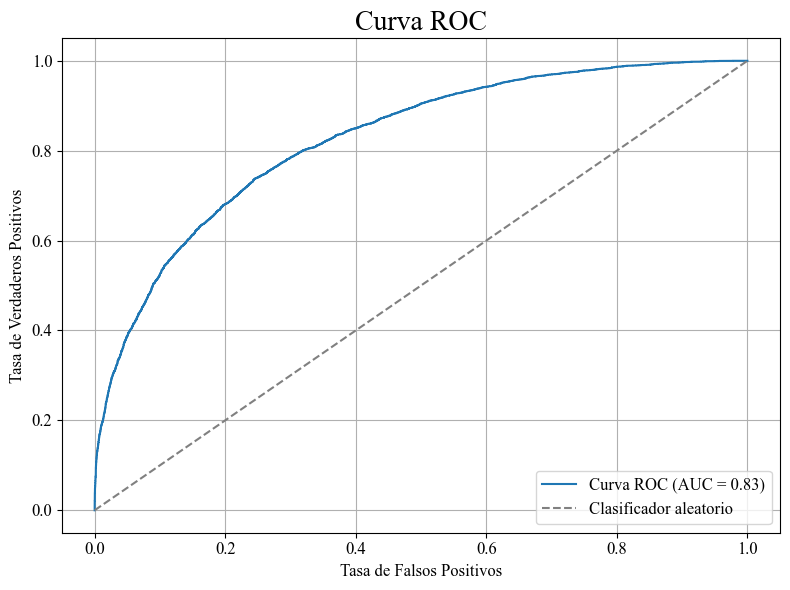


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.78      0.79     10209
           1       0.67      0.70      0.69      6538

    accuracy                           0.75     16747
   macro avg       0.74      0.74      0.74     16747
weighted avg       0.75      0.75      0.75     16747


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     23822
           1       0.92      0.97      0.94     15254

    accuracy                           0.95     39076
   macro avg       0.95      0.96      0.95     39076
weighted avg       0.96      0.95      0.95     39076



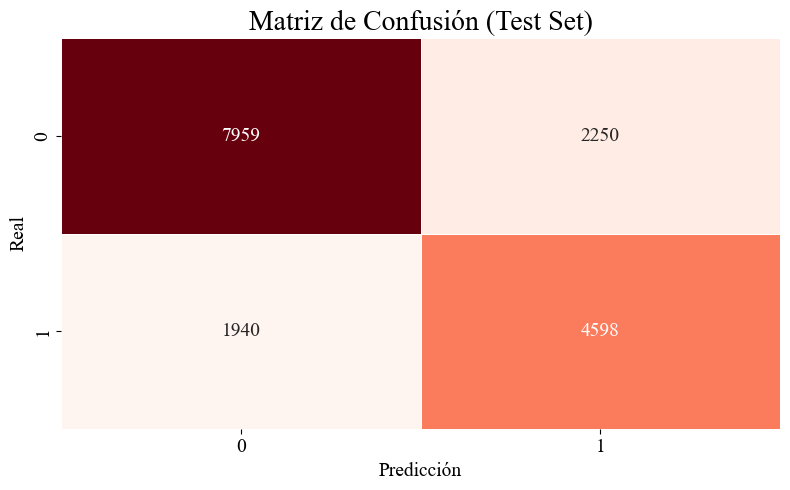

In [47]:
# Random Forest
rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': st.randint(150, 500),
    'max_depth': st.randint(1, 25),
    'max_features': st.randint(1, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True, False],
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy']
}




y_pred_train_rf_benchmark, y_prob_train_rf_benchmark, y_pred_test_rf_benchmark, y_prob_test_rf_benchmark = run_classifier_benchmark(
    rf, param_grid, 'Random Forest'
)

In [48]:
# Hacer nuevas predicciones seteando el umbral
y_pred_optimal_test_rf_benchmark = (y_prob_test_rf_benchmark >= 0.43).astype(int)
y_pred_optimal_train_rf_benchmark = (y_prob_train_rf_benchmark >= 0.43).astype(int)

# Print classification report para el conjunto de prueba
print("\nReporte de Clasificación (Test Set):")
print(classification_report(y_test_benchmark, y_pred_optimal_test_rf_benchmark))

# Print classification report para el conjunto de entrenamiento
print("\nReporte de Clasificación (Train Set):")
print(classification_report(y_train_benchmark, y_pred_optimal_train_rf_benchmark))


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.68      0.75     10209
           1       0.62      0.80      0.70      6538

    accuracy                           0.73     16747
   macro avg       0.73      0.74      0.72     16747
weighted avg       0.75      0.73      0.73     16747


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     23822
           1       0.84      0.99      0.91     15254

    accuracy                           0.92     39076
   macro avg       0.92      0.94      0.92     39076
weighted avg       0.93      0.92      0.93     39076



El modelo utilizado en el trabajo de referencia era Random Forest (Clur, M., 2022). Al hacer la comparación, se obtuvieron mejores resultados en el presente trabajo, con un punto porcentual más de AUC, de recall, precision y de f1-score para la clase positiva. Sin embargo, al observar los resultados en training se ve que hay overfitting.

A continuación se realiza una prueba para ver como performa CatBoost:

In [49]:
def run_classifier_catboost(X_train, X_test, y_train, y_test, est, param_grid, titulo):

    """
    Ejecuta búsqueda aleatoria de hiperparámetros con validación cruzada estratificada para un modelo CatBoost,
    entrena con los mejores parámetros, y muestra métricas y gráficos de evaluación.

    Parámetros:
        X_train: DataFrame con datos de entrenamiento.
        X_test: DataFrame con con datos de prueba.
        y_train: Serie con etiquetas de entrenamiento.
        y_test: Serie con etiquetas de prueba.
        est: estimador CatBoost 
        param_grid: diccionario con rangos de hiperparámetros para búsqueda aleatoria.
        titulo: string con el título del modelo corrido

    Retorna:
        best_estimator: modelo entrenado con mejores parámetros.
        y_pred_train: predicciones binarias en conjunto de entrenamiento.
        y_prob_train: probabilidades de clase positiva en entrenamiento.
        y_pred_test: predicciones binarias en conjunto de prueba.
        y_prob_test: probabilidades de clase positiva en prueba.
    """
    # -----------------------------------------------------
    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # Randomized Search
    n_iter_search = 15
    rs = RandomizedSearchCV(
        est,
        param_distributions=param_grid,
        n_iter=n_iter_search,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        refit=True
    )

    # -----------------------------------------------------
    # CatBoost: columnas categóricas
    cat_features = X_train.select_dtypes(include='object').columns.tolist()
    fit_params = {
        "cat_features": cat_features
    }

    # -----------------------------------------------------
    # Entrenar modelo
    start_time = time.time()
    rs.fit(X_train, y_train, **fit_params)
    end_time = time.time()
    print("Los mejores parámetros son %s" % (rs.best_params_))
    print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")

    # -----------------------------------------------------
    # Predicciones prueba
    y_pred_test = rs.best_estimator_.predict(X_test)
    y_prob_test = rs.best_estimator_.predict_proba(X_test)[:, 1]

    # Predicciones entrenamiento
    y_pred_train = rs.best_estimator_.predict(X_train)
    y_prob_train = rs.best_estimator_.predict_proba(X_train)[:, 1]

    # -----------------------------------------------------
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
    auc = roc_auc_score(y_test, y_prob_test)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador aleatorio')
    plt.title('Curva ROC', fontsize=20, fontname='Times New Roman')
    plt.xlabel('Tasa de Falsos Positivos', fontsize=12, fontname='Times New Roman')
    plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontname='Times New Roman')
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')
    plt.legend(loc='lower right', prop={'size': 12, 'family': 'Times New Roman'})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    print("\nReporte de Clasificación (Test Set):")
    print(classification_report(y_test, y_pred_test))

    print("\nReporte de Clasificación (Train Set):")
    print(classification_report(y_train, y_pred_train))

    # -----------------------------------------------------
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(
    cm,
    annot=True,
    cbar=False,
    fmt="d",
    linewidths=0.5,
    cmap="Reds",
    ax=ax,
    annot_kws={"size": 14, "fontname": "Times New Roman"}  
    )

    ax.set_title("Matriz de Confusión (Test Set)", fontsize=20, fontname="Times New Roman")
    ax.set_xlabel("Predicción", fontsize=14, fontname="Times New Roman")
    ax.set_ylabel("Real", fontsize=14, fontname="Times New Roman")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname="Times New Roman")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    return rs.best_estimator_, y_pred_train, y_prob_train, y_pred_test, y_prob_test


In [50]:
# Es necesario volver a hacer split en training y testing ya que CatBoost no necesita dummies

# Define variable objetivo
y_benchmark_2 = df_benchmark['eva_riesgo_2']

# Define variables explicativas
X_benchmark_2 = df_benchmark.drop(["eva_riesgo_2",'eva_riesgo','eva_riesgo_3'], axis = 1)

#Se dividen en training y testing 70/30
X_train_benchmark_2, X_test_benchmark_2, y_train_benchmark_2, y_test_benchmark_2 = train_test_split(X_benchmark_2, y_benchmark_2, stratify=y_benchmark_2, random_state=14,test_size=0.3)

# Separar columnas numéricas y categóricas
num_cols = X_train_benchmark_2.select_dtypes(include='number').columns
cat_cols = X_train_benchmark_2.select_dtypes(exclude='number').columns

# Crear y ajustar el scaler solo con columnas numéricas
scaler = StandardScaler()
scaler.fit(X_train_benchmark_2[num_cols])

# Transformar X_train y X_test solo en columnas numéricas
X_train_scaled_benchmark_2 = pd.DataFrame(scaler.transform(X_train_benchmark_2[num_cols]), columns=num_cols, index=X_train_benchmark_2.index)
X_test_scaled_benchmark_2 = pd.DataFrame(scaler.transform(X_test_benchmark_2[num_cols]), columns=num_cols, index=X_test_benchmark_2.index)

# Concatenar columnas numéricas escaladas con categóricas originales
X_train_benchmark_2 = pd.concat([X_train_scaled_benchmark_2, X_train_benchmark_2[cat_cols]], axis=1)
X_test_benchmark_2 = pd.concat([X_test_scaled_benchmark_2, X_test_benchmark_2[cat_cols]], axis=1)

Los mejores parámetros son {'random_strength': 1.7599169067012421, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.21298611422285402, 'l2_leaf_reg': 30, 'bagging_temperature': 1.5795455820738642}
Tiempo de entrenamiento: 14.45 segundos


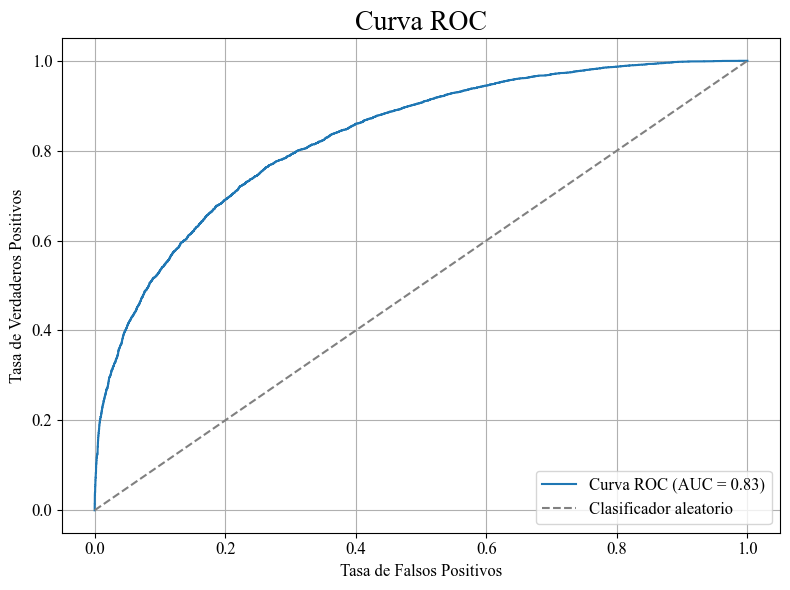


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     10209
           1       0.72      0.62      0.67      6538

    accuracy                           0.76     16747
   macro avg       0.75      0.74      0.74     16747
weighted avg       0.76      0.76      0.76     16747


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     23822
           1       0.77      0.68      0.72     15254

    accuracy                           0.80     39076
   macro avg       0.79      0.78      0.78     39076
weighted avg       0.80      0.80      0.79     39076



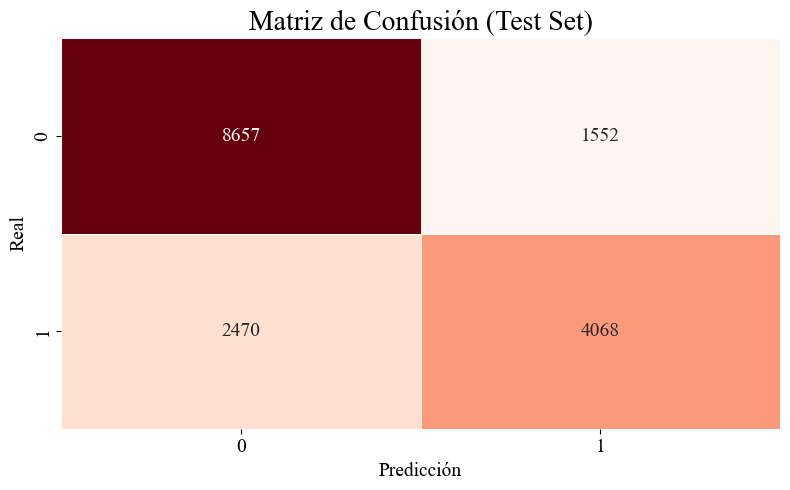

In [ ]:
# Catboost

param_grid = {
    "n_estimators": st.randint(100, 500),
    "learning_rate": st.uniform(0.01, 0.3),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 31),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}

catboost = CatBoostClassifier(
    loss_function='Logloss',
    verbose=False,
    subsample=0.8,
    random_state=34
)

model_bench_2,y_pred_optimal_train_bench_2, y_prob_train_bench_2, y_pred_optimal_test_bench_2, y_prob_test_bench_2 = run_classifier_catboost(X_train_benchmark_2, X_test_benchmark_2, y_train_benchmark_2, y_test_benchmark_2, catboost, param_grid, "Catboost")

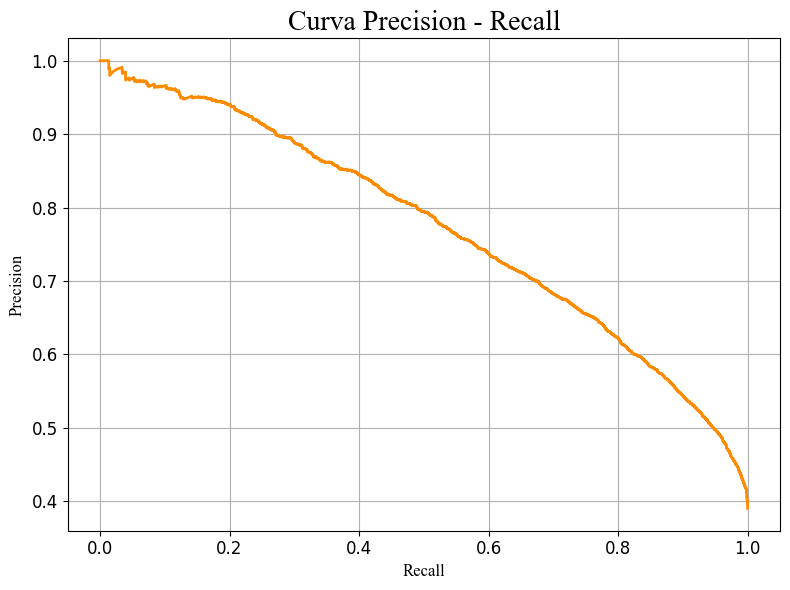

In [52]:
# Calcular los valores de precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test_benchmark_2, y_prob_test_bench_2)

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall', fontsize=12, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=12, fontname='Times New Roman')
plt.title('Curva Precision - Recall', fontsize=20, fontname='Times New Roman')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# Hacer nuevas predicciones seteando el umbral
y_pred_optimal_test_cat_benchmark = (y_prob_test_bench_2 >= 0.32).astype(int)
y_pred_optimal_train_cat_benchmark = (y_prob_train_bench_2 >= 0.32).astype(int)

# Print classification report para el conjunto de prueba
print("\nReporte de Clasificación (Test Set):")
print(classification_report(y_test_benchmark_2, y_pred_optimal_test_cat_benchmark))

# Print classification report para el conjunto de entrenamiento
print("\nReporte de Clasificación (Train Set):")
print(classification_report(y_train_benchmark_2, y_pred_optimal_train_cat_benchmark))


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.66      0.74     10209
           1       0.61      0.81      0.70      6538

    accuracy                           0.72     16747
   macro avg       0.73      0.74      0.72     16747
weighted avg       0.75      0.72      0.73     16747


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.88      0.69      0.78     23822
           1       0.64      0.85      0.73     15254

    accuracy                           0.76     39076
   macro avg       0.76      0.77      0.75     39076
weighted avg       0.79      0.76      0.76     39076



Como se puede observar, CatBoost obtuvo una mejor performance que Random Forest en terminos de recall. Ademas, los valores en training y testing son similares.

### 4. Entrenamiento de CatBoost con variable objetivo multicategórica

In [54]:
# Se copia df para no modificar el original

df_1=df.copy()


In [55]:
# Se construye variable objetivo numérica

df_1.loc[(df_1['eva_riesgo']=='SIN RIESGO'), 'eva_riesgo']=5
df_1.loc[(df_1['eva_riesgo']=='ALTISIMO'), 'eva_riesgo']=4
df_1.loc[(df_1['eva_riesgo']=='ALTO'), 'eva_riesgo']=3
df_1.loc[(df_1['eva_riesgo']=='MEDIO'), 'eva_riesgo']=2
df_1.loc[(df_1['eva_riesgo']=='MODERADO'), 'eva_riesgo']=1
df_1.loc[(df_1['eva_riesgo']=='BAJO'), 'eva_riesgo']=0
df_1['eva_riesgo']=df_1['eva_riesgo'].astype('int')
y_1 = df_1['eva_riesgo']

In [56]:
# Se definen variables explicativas
X_1 = df_1.drop(["eva_riesgo_2",'eva_riesgo','eva_riesgo_3'], axis = 1)
X_1 = pd.get_dummies(X_1, drop_first=True)

In [57]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, stratify=y_1, random_state=14,test_size=0.3)

In [58]:
# Separar columnas numéricas y categóricas
num_cols = X_train_1.select_dtypes(include='number').columns
cat_cols = X_train_1.select_dtypes(exclude='number').columns

# Crear y ajustar el scaler solo con columnas numéricas
scaler = StandardScaler()
scaler.fit(X_train_1[num_cols])

# Transformar X_train_1 y X_test_1 solo en columnas numéricas
X_train_1_scaled = pd.DataFrame(scaler.transform(X_train_1[num_cols]), columns=num_cols, index=X_train_1.index)
X_test_1_scaled = pd.DataFrame(scaler.transform(X_test_1[num_cols]), columns=num_cols, index=X_test_1.index)

# Concatenar columnas numéricas escaladas con categóricas originales
X_train_1 = pd.concat([X_train_1_scaled, X_train_1[cat_cols]], axis=1)
X_test_1 = pd.concat([X_test_1_scaled, X_test_1[cat_cols]], axis=1)


In [59]:
def run_classifier_multiclase_auc(est, param_grid, titulo):

    """
    Realiza búsqueda aleatoria de hiperparámetros y entrenamiento de un clasificador multiclase,
    evaluando con métricas de clasificación, AUC multiclasificación y matriz de confusión.

    Parámetros:
    - est: estimador compatible con scikit-learn (por ejemplo, CatBoostClassifier).
    - param_grid: diccionario con distribuciones de hiperparámetros para RandomizedSearchCV.
    - titulo: string con titulo del modelo utilizado


    Retorna:
    - y_pred_train: predicciones en el conjunto de entrenamiento.
    - y_prob_train: probabilidades predichas en el conjunto de entrenamiento.
    - y_pred_test: predicciones en el conjunto de prueba.
    - y_prob_test: probabilidades predichas en el conjunto de prueba.
    """

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    rs = RandomizedSearchCV(
        estimator=est,
        param_distributions=param_grid,
        n_iter=15,
        cv=cv,
        scoring='f1_macro',
        verbose=1,
        n_jobs=-1,
        refit=True
    )

    # Detectar columnas categóricas 
    cat_cols = X_train_1.select_dtypes(include='object').columns
    cat_features = [X_train_1.columns.get_loc(col) for col in cat_cols]

    # Fit 
    rs.fit(
        X_train_1, y_train_1,
        cat_features=cat_features,
        verbose=False
    )

    print("Los mejores parámetros son:", rs.best_params_)

    y_pred_test = rs.predict(X_test_1)
    y_pred_train = rs.predict(X_train_1)

    y_prob_test = rs.predict_proba(X_test_1)
    y_prob_train = rs.predict_proba(X_train_1)

    classes = rs.best_estimator_.classes_
    y_test_bin = label_binarize(y_test_1, classes=classes)

    auc_test = roc_auc_score(y_test_bin, y_prob_test, multi_class='ovr')
    print(f"AUC multiclasificación (Test): {auc_test:.3f}")

    print("\nReporte de Clasificación (Test Set):")
    print(classification_report(y_test_1, y_pred_test))

    print("\nReporte de Clasificación (Train Set):")
    print(classification_report(y_train_1, y_pred_train))

    # Matriz de confusión
    fig, ax = plt.subplots(figsize=(10, 5))
    cm = confusion_matrix(y_test_1, y_pred_test)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'{titulo} (Test Set)')
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    plt.tight_layout()
    plt.show()

    return y_pred_train, y_prob_train, y_pred_test, y_prob_test

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Los mejores parámetros son: {'bagging_temperature': 5.10921324943199, 'l2_leaf_reg': 22, 'learning_rate': 0.1538876858023007, 'max_depth': 11, 'n_estimators': 494, 'random_strength': 1.319920355821322}
AUC multiclasificación (Test): 0.799

Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.51      0.45      0.47      2825
           1       0.39      0.35      0.37      5850
           2       0.43      0.50      0.46      9264
           3       0.52      0.58      0.55      8805
           4       0.61      0.13      0.21      1742
           5       0.43      0.03      0.06       202

    accuracy                           0.46     28688
   macro avg       0.48      0.34      0.35     28688
weighted avg       0.47      0.46      0.45     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.77  

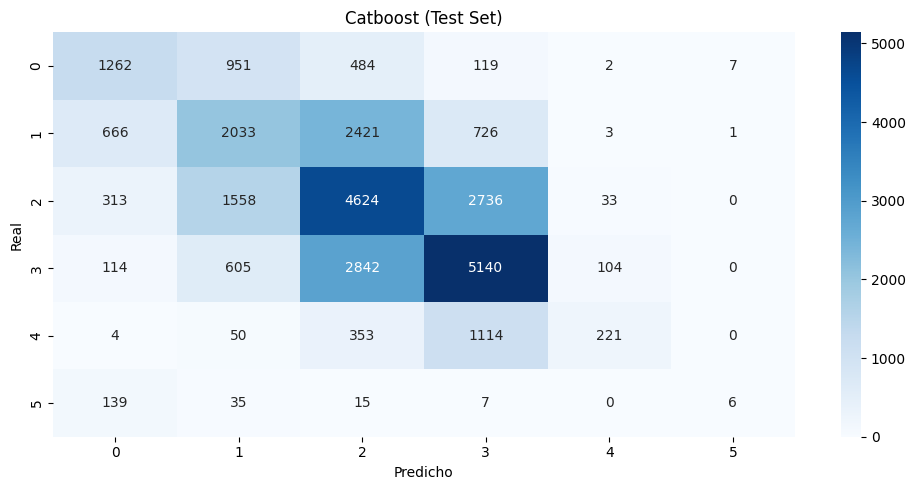

In [60]:
# Catboost

param_grid = {
    "n_estimators": st.randint(50, 500),
    "learning_rate": st.uniform(0.01, 0.2),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 30),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}

catboost = CatBoostClassifier(
   loss_function='MultiClass', verbose=False,random_state=34)

y_pred_train_cat_1, y_prob_train_cat_1, y_pred_test_cat_1, y_prob_test_cat_1 = run_classifier_multiclase_auc(catboost, param_grid, "Catboost")

### 5. Entrenamiento de CatBoost con riesgo binarizado (Altísimo = 1, resto = 0)

In [61]:
df_altisimo=df.copy()
df_altisimo['eva_riesgo_3'] = df_altisimo['eva_riesgo_3'].astype(int)
y_altisimo = df['eva_riesgo_3']

In [62]:
X_altisimo = df_altisimo.drop(["eva_riesgo_2",'eva_riesgo','eva_riesgo_3'], axis = 1)
X_altisimo = pd.get_dummies(X_altisimo, drop_first=True)

In [63]:
#Se dividen en training y testing
X_train_altisimo, X_test_altisimo, y_train_altisimo, y_test_altisimo = train_test_split(X_altisimo, y_altisimo, stratify=y_altisimo, random_state=14,test_size=0.3)

In [64]:
# Separar columnas numéricas y categóricas
num_cols = X_train_altisimo.select_dtypes(include='number').columns
cat_cols = X_train_altisimo.select_dtypes(exclude='number').columns

# Crear y ajustar el scaler solo con columnas numéricas
scaler_altisimo = StandardScaler()
scaler_altisimo.fit(X_train_altisimo[num_cols])

# Transformar X_train y X_test solo en columnas numéricas
X_train_scaled_altisimo = pd.DataFrame(scaler_altisimo.transform(X_train_altisimo[num_cols]), columns=num_cols, index=X_train_altisimo.index)
X_test_scaled_altisimo = pd.DataFrame(scaler_altisimo.transform(X_test_altisimo[num_cols]), columns=num_cols, index=X_test_altisimo.index)

# Concatenar columnas numéricas escaladas con categóricas originales
X_train_altisimo = pd.concat([X_train_scaled_altisimo, X_train_altisimo[cat_cols]], axis=1)
X_test_altisimo = pd.concat([X_test_scaled_altisimo, X_test_altisimo[cat_cols]], axis=1)


Los mejores parámetros son {'random_strength': 0.25039791939888656, 'n_estimators': 422, 'max_depth': 6, 'learning_rate': 0.0968341733178568, 'l2_leaf_reg': 25, 'bagging_temperature': 0.3168926721552747}
Tiempo de entrenamiento: 6.79 segundos


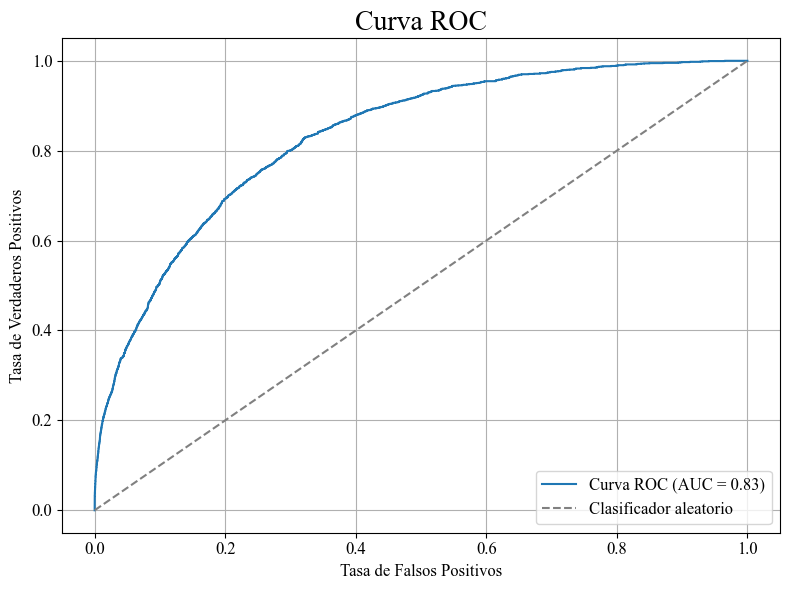


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     26946
           1       0.77      0.08      0.14      1742

    accuracy                           0.94     28688
   macro avg       0.85      0.54      0.56     28688
weighted avg       0.93      0.94      0.92     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     62874
           1       0.95      0.13      0.22      4063

    accuracy                           0.95     66937
   macro avg       0.95      0.56      0.60     66937
weighted avg       0.95      0.95      0.93     66937



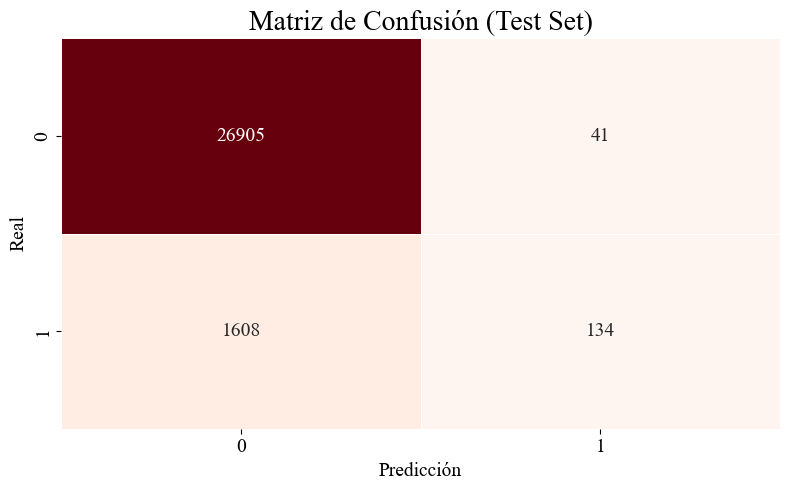

In [ ]:
# Catboost

param_grid = {
    "n_estimators": st.randint(100, 500),
    "learning_rate": st.uniform(0.01, 0.3),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 31),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}


catboost = CatBoostClassifier(
    loss_function='Logloss',
    verbose=False,
    subsample=0.8,
    random_state=34
)

model_altisimo, y_pred_train_cat_altisimo, y_prob_train_cat_altisimo, y_pred_test_cat_altisimo, y_prob_test_cat_altisimo = run_classifier_catboost(X_train_altisimo, X_test_altisimo, y_train_altisimo, y_test_altisimo,catboost, param_grid, "Catboost")

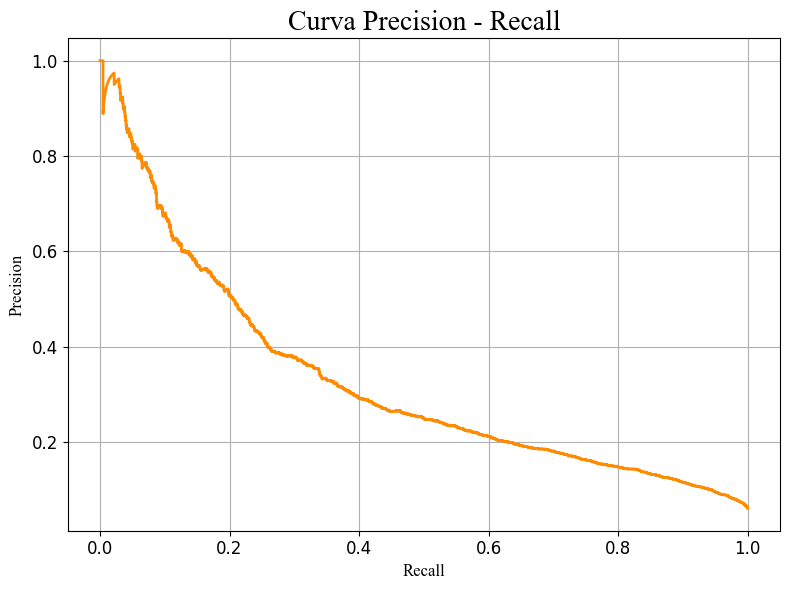

In [66]:
# Calcular los valores de precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test_altisimo, y_prob_test_cat_altisimo)

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall', fontsize=12, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=12, fontname='Times New Roman')
plt.title('Curva Precision - Recall', fontsize=20, fontname='Times New Roman')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# Hacer nuevas predicciones seteando el umbral
y_pred_optimal_test = (y_prob_test_cat_altisimo >= 0.325).astype(int)
y_pred_optimal_train = (y_prob_test_cat_altisimo >= 0.325).astype(int)

# Print classification report para el conjunto de prueba
print("\nReporte de Clasificación (Test Set):")
print(classification_report(y_test_altisimo, y_pred_optimal_test))

# Print classification report para el conjunto de entrenamiento
print("\nReporte de Clasificación (Train Set):")
print(classification_report(y_test_altisimo, y_pred_optimal_train))


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26946
           1       0.55      0.17      0.26      1742

    accuracy                           0.94     28688
   macro avg       0.75      0.58      0.62     28688
weighted avg       0.92      0.94      0.93     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     26946
           1       0.55      0.17      0.26      1742

    accuracy                           0.94     28688
   macro avg       0.75      0.58      0.62     28688
weighted avg       0.92      0.94      0.93     28688



No se obtuvieron buenos resultados debido al gran desbalance entre clases. Por esta razón, el siguiente paso es utilizar como variable objetivo los casos de riesgo alto y altisimo como clase positiva.

### 6. Entrenamiento de CatBoost con riesgo binarizado (Altísimo o Alto = 1, resto = 0)

In [40]:
# Se define variable objetivo
df['eva_riesgo_2'] = df['eva_riesgo_2'].astype(int)
y = df['eva_riesgo_2']

In [41]:
# Se definen variables explicativas
X = df.drop(["eva_riesgo_2",'eva_riesgo','eva_riesgo_3'], axis = 1)

In [45]:
#Se dividen en training y testing 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=14,test_size=0.3)

In [71]:
# Separar columnas numéricas y categóricas
num_cols = X_train.select_dtypes(include='number').columns
cat_cols = X_train.select_dtypes(exclude='number').columns

# Crear y ajustar el scaler solo con columnas numéricas
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

# Transformar X_train y X_test solo en columnas numéricas
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# Concatenar columnas numéricas escaladas con categóricas originales
X_train = pd.concat([X_train_scaled, X_train[cat_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[cat_cols]], axis=1)

# Se agrega class weights para darle mas peso a la clase minoritaria
class_counts = Counter(y_train)
total = sum(class_counts.values())
n_classes = len(class_counts)
class_weights = [total / (n_classes * class_counts[i]) for i in sorted(class_counts)]


Los mejores parámetros son {'random_strength': 0.33157787098385794, 'n_estimators': 430, 'max_depth': 11, 'learning_rate': 0.04531280060385252, 'l2_leaf_reg': 6, 'bagging_temperature': 0.2329329670175312}
Tiempo de entrenamiento: 126.24 segundos


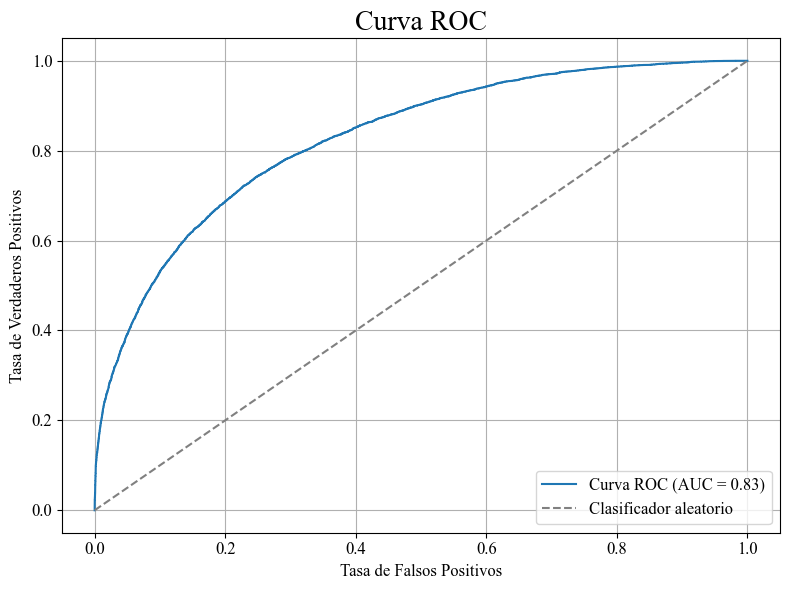


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.76      0.79     18141
           1       0.64      0.73      0.68     10547

    accuracy                           0.75     28688
   macro avg       0.74      0.75      0.74     28688
weighted avg       0.76      0.75      0.75     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     42329
           1       0.73      0.83      0.78     24608

    accuracy                           0.83     66937
   macro avg       0.81      0.83      0.82     66937
weighted avg       0.83      0.83      0.83     66937



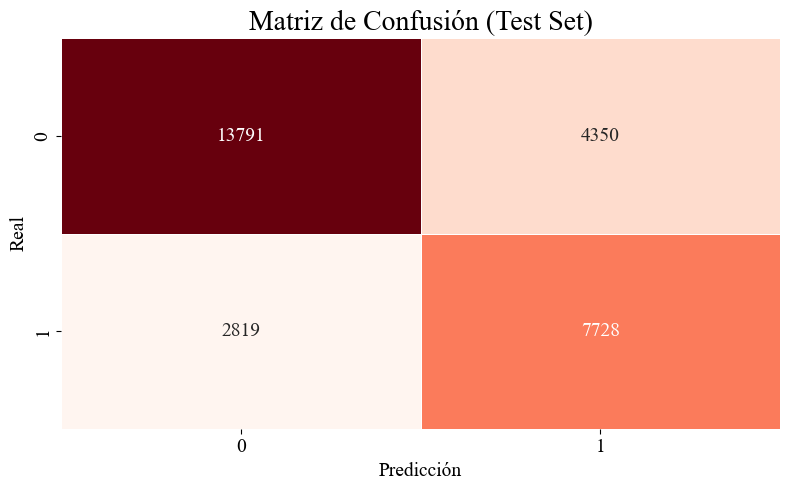

In [ ]:
# Catboost

param_grid = {
    "n_estimators": st.randint(100, 500),
    "learning_rate": st.uniform(0.01, 0.3),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 31),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}


catboost = CatBoostClassifier(
    loss_function='Logloss',
    verbose=False,
    subsample=0.8,
    random_state=34,
    class_weights=class_weights
)

model,y_pred_train_cat, y_prob_train_cat, y_pred_test_cat, y_prob_test_cat = run_classifier_catboost(X_train, X_test, y_train, y_test,catboost, param_grid, "Catboost")

#### Elección de threshold

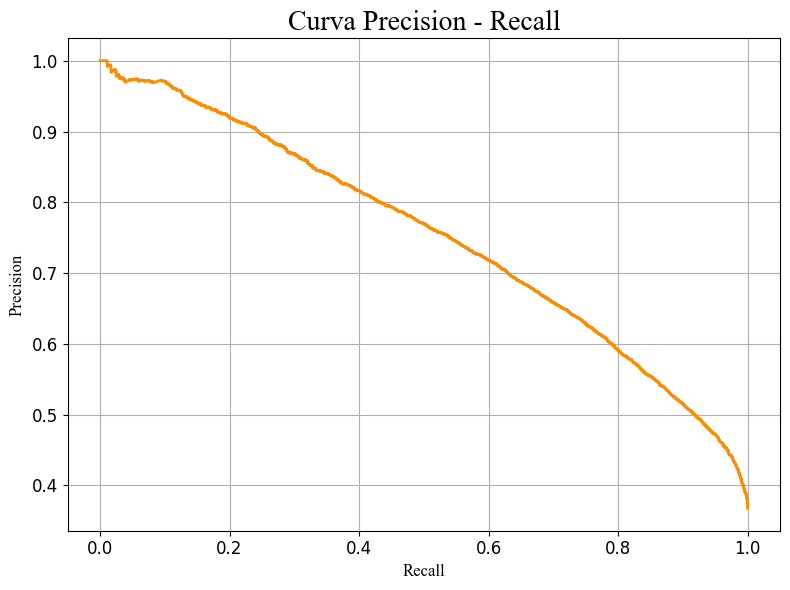

In [73]:
# Calcular los valores de precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test_cat)


# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall', fontsize=12, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=12, fontname='Times New Roman')
plt.title('Curva Precision - Recall', fontsize=20, fontname='Times New Roman')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:
# Hacer nuevas predicciones seteando el umbral
y_pred_optimal_test = (y_prob_test_cat >= 0.44).astype(int)
y_pred_optimal_train = (y_prob_train_cat >= 0.44).astype(int)

# Print classification report para el conjunto de prueba
print("\nReporte de Clasificación (Test Set):")
print(classification_report(y_test, y_pred_optimal_test))

# Print classification report para el conjunto de entrenamiento
print("\nReporte de Clasificación (Train Set):")
print(classification_report(y_train, y_pred_optimal_train))


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.85      0.70      0.77     18141
           1       0.60      0.79      0.68     10547

    accuracy                           0.73     28688
   macro avg       0.73      0.74      0.72     28688
weighted avg       0.76      0.73      0.73     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     42329
           1       0.68      0.88      0.77     24608

    accuracy                           0.81     66937
   macro avg       0.80      0.82      0.80     66937
weighted avg       0.83      0.81      0.81     66937



##### Feature Importance

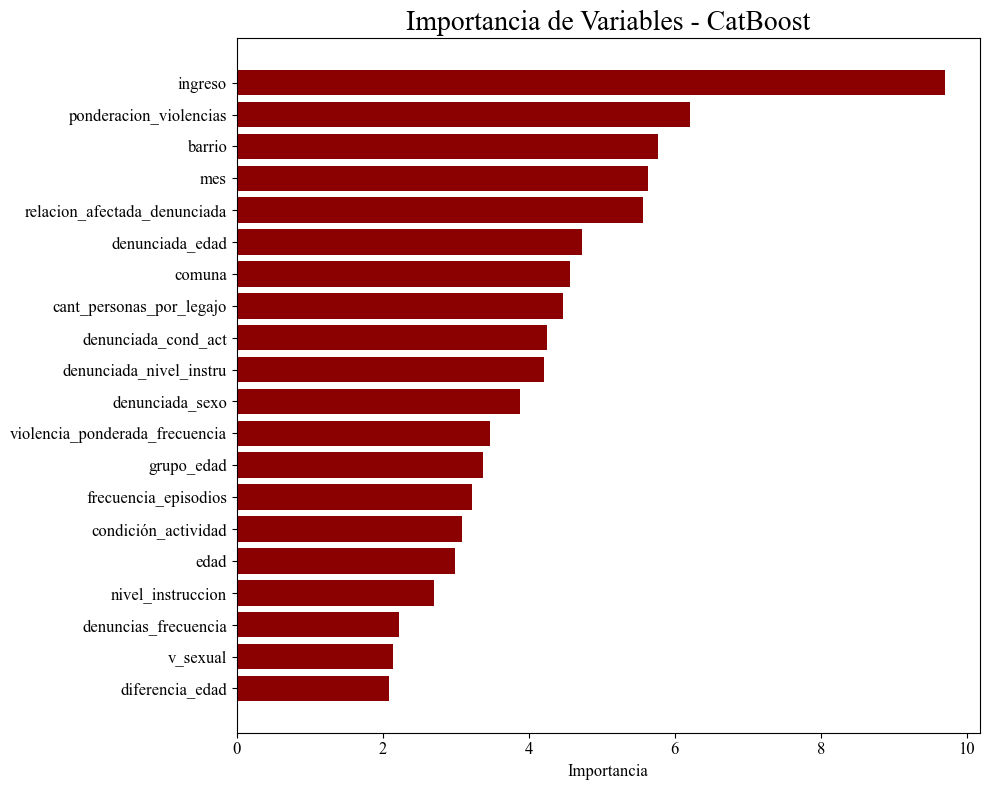

In [75]:
# Obtener la importancia directamente del modelo
feature_importances = model.get_feature_importance()
feature_names = model.feature_names_

# Crear DataFrame ordenado
df_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

df_importance_plot = df_importance.head(20)

# Graficar
plt.figure(figsize=(10, 8))
plt.barh(df_importance_plot['feature'], df_importance_plot['importance'], color='darkred')  # dark red
plt.gca().invert_yaxis()
plt.xlabel('Importancia', fontsize=12, fontname='Times New Roman')
plt.title('Importancia de Variables - CatBoost', fontsize=20, fontname='Times New Roman')
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.tight_layout()
plt.show()

- Luego del análisis del feature importance se eliminaron las variables 'flag_mayor','denuncia_otro_sexo'y 'frecuencia_codificada' del modelo. Estas fueron eliminadas al principio de la notebook para mantener coherencia entre las bases de datos.

- Una de las variables más importantes es el mes de la denuncia. Sin embargo, en el EDA esta variable no parecía tener grandes diferencias en los distintas categorias con respecto a el nivel de riesgo. Por esta razón surge la duda de si esta variable puede estar actuando en interacción con otra variable. Por ello a continuación se hace un análisis en el que en lugar de medir qué tan importante es una sola variable, el método model.get_feature_importance(data=pool, type='Interaction') evalúa cuánto contribuye una combinación de dos variables a las predicciones del modelo. Es decir, intenta capturar efectos conjuntos.

In [76]:
pool = Pool(X_train, cat_features=list(cat_cols))

# Obtener las interacciones
interacciones = model.get_feature_importance(data=pool, type='Interaction')

# Convertir a DataFrame
df_interacciones = pd.DataFrame(interacciones, columns=['Feature_1', 'Feature_2', 'Interaction_Score'])

# Convertir índices a nombres reales de las columnas
feature_names = X_train.columns.tolist()
df_interacciones['Feature_1'] = df_interacciones['Feature_1'].apply(lambda i: feature_names[int(i)])
df_interacciones['Feature_2'] = df_interacciones['Feature_2'].apply(lambda i: feature_names[int(i)])

# Filtrar las interacciones que contienen 'mes'
df_mes = df_interacciones[
    df_interacciones['Feature_1'].str.contains('mes', case=False) |
    df_interacciones['Feature_2'].str.contains('mes', case=False)
]

# Ordenar por score 
df_mes = df_mes.sort_values(by='Interaction_Score', ascending=False)

# Mostrar
df_mes

,Feature_1,Feature_2,Interaction_Score
1,barrio,mes,1.950911
21,cant_personas_por_legajo,mes,0.583517
26,edad,mes,0.546144
32,denunciada_edad,mes,0.490919
36,ingreso,mes,0.482128
45,comuna,mes,0.437756
58,ponderacion_violencias,mes,0.378437
88,diferencia_edad,mes,0.275967
102,condición_actividad,mes,0.248187
122,frecuencia_episodios,mes,0.210008


El modelo detecta que el efecto conjunto de “mes” y “barrio” aporta información relevante para predecir el riesgo. En la sección 10 de esta notebook se entrena el modelo utilizando esta nueva variable de interacción entre 'mes' y 'barrio'

### 7. Entrenamiento de CatBoost con SMOTE

In [77]:
def run_classifier_smote(est, param_grid, titulo):

    """
    Entrena un clasificador binario usando búsqueda aleatoria de hiperparámetros,
    balanceo con SMOTENC y evaluación del desempeño sobre el conjunto de prueba.

    Parámetros:
    - est: estimador
    - param_grid: diccionario con distribuciones de hiperparámetros para RandomizedSearchCV.
    - titulo: string como titulo con nombre del modelo 


    Retorna:
    - best_estimator_: el modelo entrenado con los mejores parámetros.
    - y_pred_train: predicciones binarias en el conjunto de entrenamiento.
    - y_prob_train: probabilidades en el conjunto de entrenamiento.
    - y_pred_test: predicciones binarias en el conjunto de prueba.
    - y_prob_test: probabilidades en el conjunto de prueba.
    """

    # -----------------------------------------------------
    # Detectar columnas categóricas (índices)
    cat_cols = X_train.select_dtypes(include='object').columns
    cat_features_idx = [X_train.columns.get_loc(col) for col in cat_cols]

    # -----------------------------------------------------
    # Aplicar SMOTENC solo al set de entrenamiento
    smote = SMOTENC(categorical_features=cat_features_idx, random_state=123,sampling_strategy=0.7)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # -----------------------------------------------------
    # Validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # Randomized Search
    n_iter_search = 30
    rs = RandomizedSearchCV(
        est,
        param_distributions=param_grid,
        n_iter=n_iter_search,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        refit=True
    )

    # -----------------------------------------------------
    # Ajustar modelo con datos balanceados
    fit_params = {
        "cat_features": cat_features_idx
    }

    rs.fit(X_train_resampled, y_train_resampled, **fit_params)
    print("Los mejores parámetros son %s" % (rs.best_params_))

    # -----------------------------------------------------
    # Predicciones sobre test
    y_pred_test = rs.best_estimator_.predict(X_test)
    y_prob_test = rs.best_estimator_.predict_proba(X_test)[:, 1]

    # Predicciones sobre train original
    y_pred_train = rs.best_estimator_.predict(X_train)
    y_prob_train = rs.best_estimator_.predict_proba(X_train)[:, 1]

    # -----------------------------------------------------
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
    auc = roc_auc_score(y_test, y_prob_test)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador aleatorio')
    plt.title('Curva ROC', fontsize=20, fontname='Times New Roman')
    plt.xlabel('Tasa de Falsos Positivos', fontsize=12, fontname='Times New Roman')
    plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontname='Times New Roman')
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')
    plt.legend(loc='lower right', prop={'size': 12, 'family': 'Times New Roman'})
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # Ajuste con umbral óptimo 
    y_pred_optimal_test = (y_prob_test >= 0.5).astype(int)
    y_pred_optimal_train = (y_prob_train >= 0.5).astype(int)

    print("\nReporte de Clasificación (Test Set):")
    print(classification_report(y_test, y_pred_optimal_test))

    print("\nReporte de Clasificación (Train Set):")
    print(classification_report(y_train, y_pred_optimal_train))

    # -----------------------------------------------------
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_optimal_test)
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(
    cm,
    annot=True,
    cbar=False,
    fmt="d",
    linewidths=0.5,
    cmap="Reds",
    ax=ax,
    annot_kws={"size": 14, "fontname": "Times New Roman"}  
    )

    ax.set_title("Matriz de Confusión (Test Set)", fontsize=20, fontname="Times New Roman")
    ax.set_xlabel("Predicción", fontsize=14, fontname="Times New Roman")
    ax.set_ylabel("Real", fontsize=14, fontname="Times New Roman")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname="Times New Roman")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()


    # -----------------------------------------------------
    return rs.best_estimator_, y_pred_optimal_train, y_prob_train, y_pred_optimal_test, y_prob_test


Los mejores parámetros son {'bagging_temperature': 0.7451232344443111, 'l2_leaf_reg': 13, 'learning_rate': 0.16306136881651742, 'max_depth': 10, 'n_estimators': 434, 'random_strength': 0.5069685705891633}


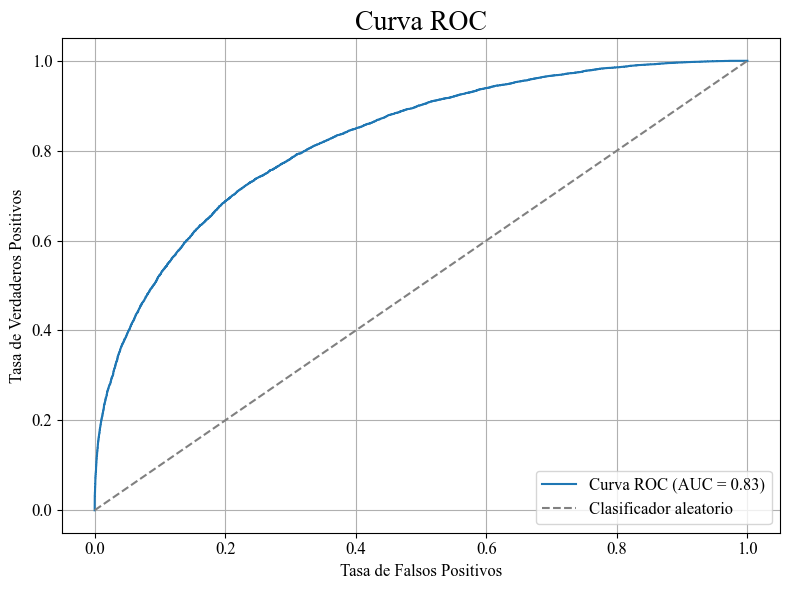


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     18141
           1       0.71      0.61      0.66     10547

    accuracy                           0.76     28688
   macro avg       0.75      0.73      0.74     28688
weighted avg       0.76      0.76      0.76     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     42329
           1       0.84      0.73      0.78     24608

    accuracy                           0.85     66937
   macro avg       0.85      0.83      0.83     66937
weighted avg       0.85      0.85      0.85     66937



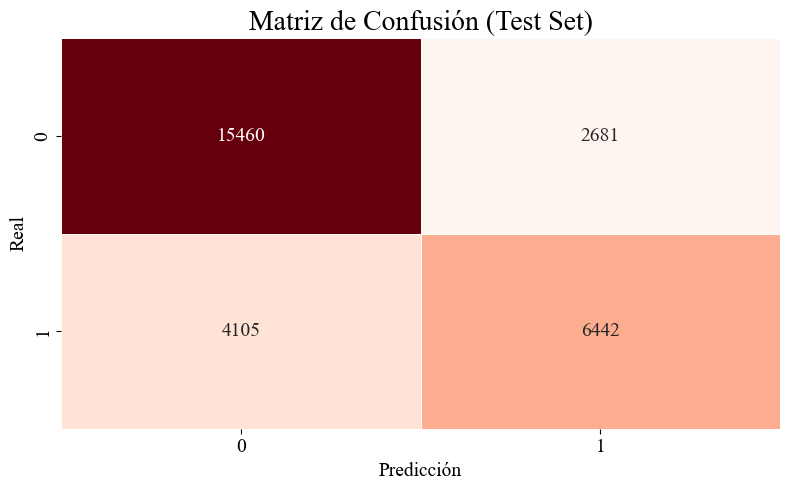

In [78]:
param_grid = {
    "n_estimators": st.randint(50, 500),
    "learning_rate": st.uniform(0.01, 0.2),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 30),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}


catboost = CatBoostClassifier(
    loss_function='Logloss',
    verbose=False,
    subsample=0.8,
    random_state=34
)

model_smote,y_pred_train_catl_smote, y_prob_train_catl_smote, y_pred_test_catl_smote, y_prob_test_catl_smote = run_classifier_smote(catboost, param_grid, "Catboost")

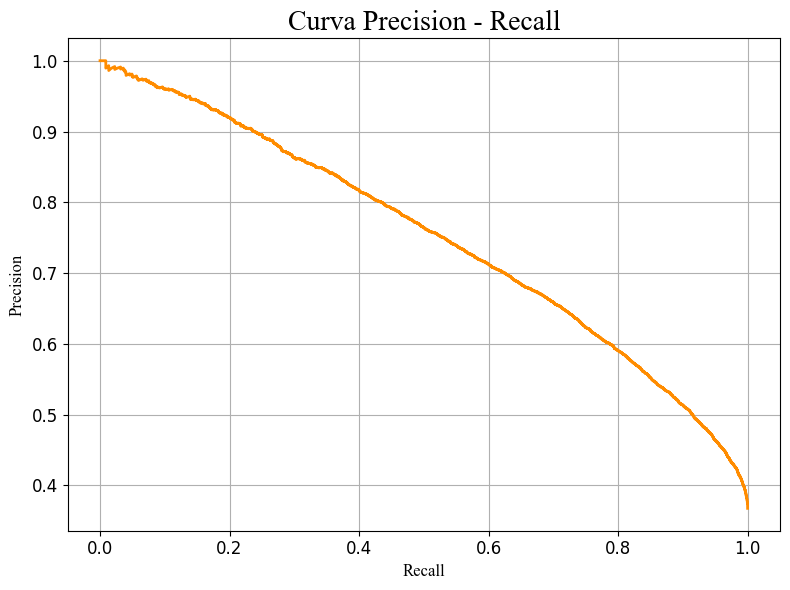

In [79]:
# Calcular los valores de precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_test_catl_smote)

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall', fontsize=12, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=12, fontname='Times New Roman')
plt.title('Curva Precision - Recall', fontsize=20, fontname='Times New Roman')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### 8. Se prueban otros algoritmos

In [42]:
# Se define nuevamente la variable X ya que se necesitan variables dummies para los modelos que no son CatBoost
X_otros = pd.get_dummies(X, drop_first=True)

# Guardar columnas numéricas originales (antes de hacer dummies)
columnas_numericas_originales = X.select_dtypes(include=["number"]).columns.tolist()

# Split training/testing 70/30
X_train_otros, X_test_otros, y_train_otros, y_test_otros = train_test_split(
    X_otros, y, stratify=y, random_state=14, test_size=0.3
)

# Reemplaza espacios en los nombres de columnas por guiones bajos
X_train_otros.columns = X_train_otros.columns.str.replace(' ', '_')
X_test_otros.columns = X_test_otros.columns.str.replace(' ', '_')

# Inicializar y ajustar scaler solo con columnas numéricas originales
scaler = StandardScaler()
scaler.fit(X_train_otros[columnas_numericas_originales])

# Copiar datasets y reemplazar solo las columnas numéricas con los valores escalados
X_train_otros_scaled = X_train_otros.copy()
X_test_otros_scaled = X_test_otros.copy()

X_train_otros_scaled[columnas_numericas_originales] = scaler.transform(X_train_otros[columnas_numericas_originales])
X_test_otros_scaled[columnas_numericas_originales] = scaler.transform(X_test_otros[columnas_numericas_originales])


In [43]:
def run_classifier_otros(est, param_grid, titulo):
    """
    Realiza búsqueda aleatoria de hiperparámetros y entrenamiento de un clasificador binario,
    evaluando el desempeño con curva ROC, AUC, reporte de clasificación y matriz de confusión.

    Parámetros:
    - est: estimador 
    - param_grid: diccionario con distribuciones o listas de hiperparámetros para RandomizedSearchCV.
    - titulo: string como titulo del modelo utilizado

    Retorna:
    - y_pred_optimal_train: predicciones binarias para conjunto de entrenamiento con umbral fijo. 
    - y_prob_train: probabilidades predichas para conjunto de entrenamiento.
    - y_pred_optimal_test: predicciones binarias para conjunto de prueba con umbral fijo. 
    - y_prob_test: probabilidades predichas para conjunto de prueba.
    """
    # -----------------------------------------------------
    # Definir validación cruzada estratificada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

    # Randomized grid search
    n_iter_search = 30
    rs= RandomizedSearchCV(est,
                            param_distributions=param_grid,
                            n_iter=n_iter_search,
                            cv=cv,
                            scoring='f1',
                            n_jobs=-1,
                            refit=True)
    # -----------------------------------------------------
    # Entrenar el modelo
    rs.fit(X_train_otros_scaled, y_train_otros)
    print("Los mejores parámetros son %s" % (rs.best_params_))


    # -----------------------------------------------------
    # Predicciones en el conjunto de prueba
    y_pred_test = rs.best_estimator_.predict(X_test_otros_scaled)
    y_prob_test = rs.best_estimator_.predict_proba(X_test_otros_scaled)[:, 1]

    # -----------------------------------------------------
    # Predicciones en el conjunto de entrenamiento
    y_pred_train = rs.best_estimator_.predict(X_train_otros_scaled)
    y_prob_train = rs.best_estimator_.predict_proba(X_train_otros_scaled)[:, 1]

    # -----------------------------------------------------
    # Calcular la curva ROC y AUC para el conjunto de prueba
    fpr, tpr, thresholds = roc_curve(y_test_otros, y_prob_test)
    auc = roc_auc_score(y_test_otros, y_prob_test)

    # Formato
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.2f})')  
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clasificador aleatorio')  



    # Plot ROC Curve
    plt.title('Curva ROC', fontsize=20, fontname='Times New Roman')
    plt.xlabel('Tasa de Falsos Positivos', fontsize=12, fontname='Times New Roman')
    plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontname='Times New Roman')
    plt.xticks(fontsize=12, fontname='Times New Roman')
    plt.yticks(fontsize=12, fontname='Times New Roman')
    plt.legend(loc='lower right', prop={'size': 12, 'family': 'Times New Roman'})

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------

    # Hacer  predicciones seteando el umbral
    y_pred_optimal_test = (y_prob_test >= 0.5).astype(int)
    y_pred_optimal_train = (y_prob_train >= 0.5).astype(int)

    # -----------------------------------------------------
    # Print classification report para el conjunto de prueba
    print("\nReporte de Clasificación (Test Set):")
    print(classification_report(y_test, y_pred_optimal_test))

    # Print classification report para el conjunto de entrenamiento
    print("\nReporte de Clasificación (Train Set):")
    print(classification_report(y_train, y_pred_optimal_train))

    # -----------------------------------------------------
    # Plot confusion matrix para el conjunto de prueba

    cm = confusion_matrix(y_test, y_pred_optimal_test)

    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(
    cm,
    annot=True,
    cbar=False,
    fmt="d",
    linewidths=0.5,
    cmap="Reds",
    ax=ax,
    annot_kws={"size": 14, "fontname": "Times New Roman"}  
    )

    ax.set_title("Matriz de Confusión (Test Set)", fontsize=20, fontname="Times New Roman")
    ax.set_xlabel("Predicción", fontsize=14, fontname="Times New Roman")
    ax.set_ylabel("Real", fontsize=14, fontname="Times New Roman")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname="Times New Roman")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname="Times New Roman")

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------
    # Retornar y_pred y y_prob para el conjunto de entrenamiento y de prueba para uso posterior
    return y_pred_optimal_train, y_prob_train, y_pred_optimal_test, y_prob_test

Los mejores parámetros son {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 11, 'max_features': 9, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 447}


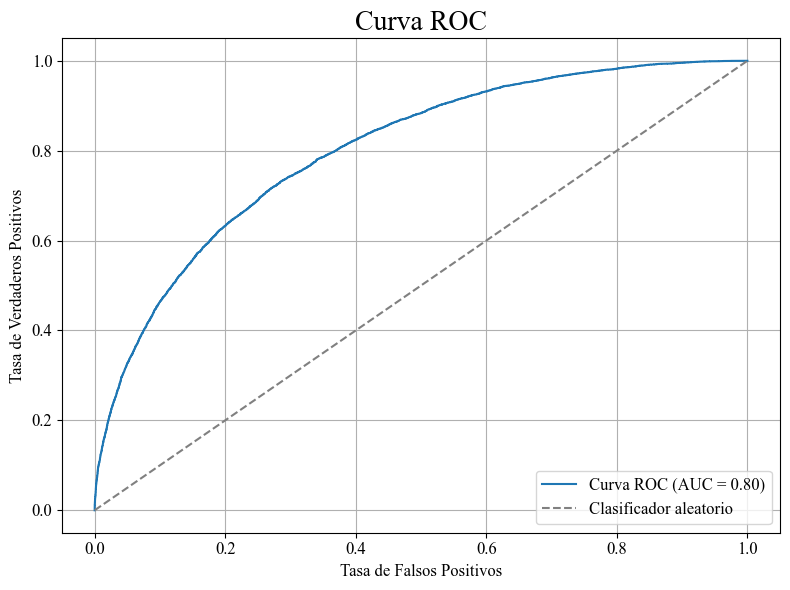


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.71      0.76     18141
           1       0.60      0.74      0.66     10547

    accuracy                           0.72     28688
   macro avg       0.71      0.72      0.71     28688
weighted avg       0.74      0.72      0.72     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.84      0.72      0.77     42329
           1       0.61      0.76      0.68     24608

    accuracy                           0.73     66937
   macro avg       0.72      0.74      0.72     66937
weighted avg       0.75      0.73      0.74     66937



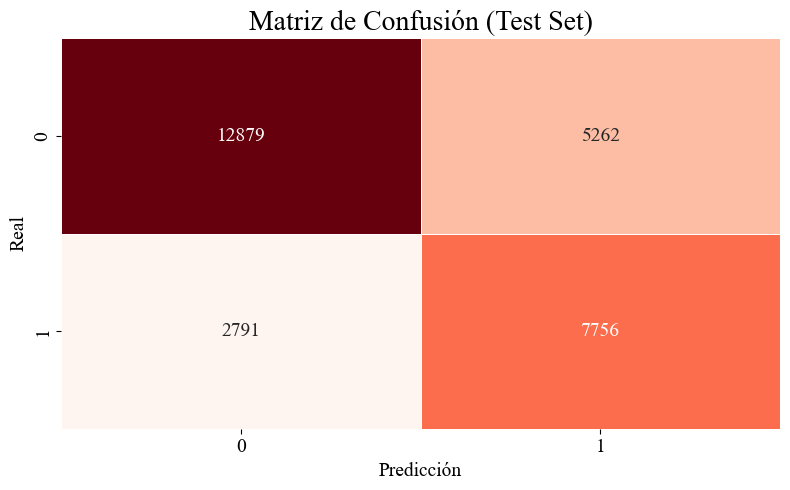

In [82]:
# Random Forest

rf = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': st.randint(50,500),
              'max_depth': st.randint(1,12),
              'max_features': st.randint(1,10),
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4, 10],
              'bootstrap': [True, False],
              'class_weight':['balanced'],
              'criterion': ['gini', 'entropy']}

y_pred_train_rf, y_prob_train_rf, y_pred_test_rf, y_prob_test_rf=run_classifier_otros(rf, param_grid, 'Random Forest')

Los mejores parámetros son {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': 9, 'min_samples_leaf': 2, 'min_samples_split': 10}


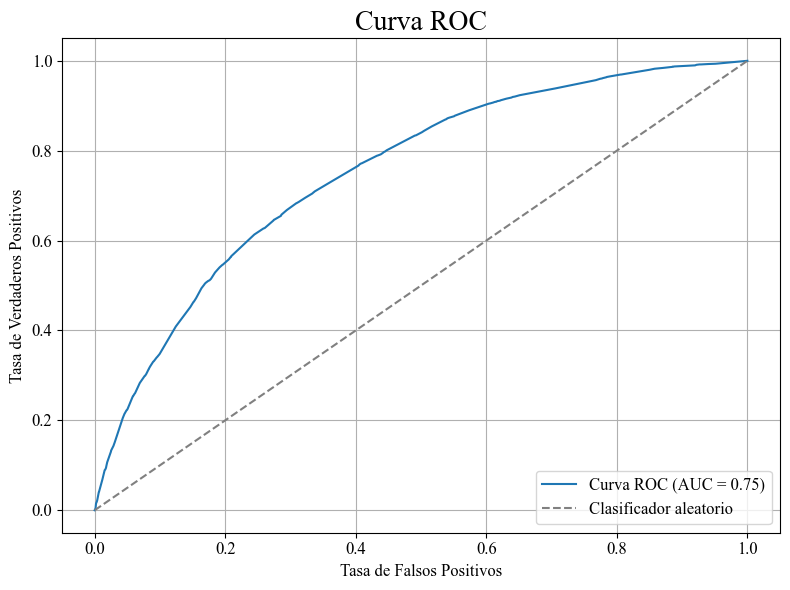


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.80      0.64      0.71     18141
           1       0.54      0.73      0.62     10547

    accuracy                           0.67     28688
   macro avg       0.67      0.68      0.67     28688
weighted avg       0.71      0.67      0.68     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.81      0.65      0.72     42329
           1       0.55      0.74      0.63     24608

    accuracy                           0.68     66937
   macro avg       0.68      0.69      0.68     66937
weighted avg       0.72      0.68      0.69     66937



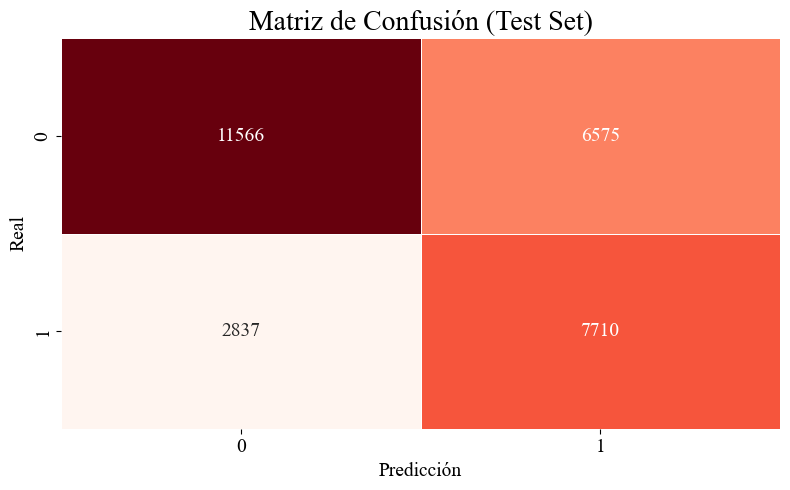

In [83]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)

param_grid_dt = {
    'max_depth': st.randint(1, 12),
    'max_features': st.randint(1, 10),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'class_weight': ['balanced'],
    'criterion': ['gini', 'entropy']
}


y_pred_train_dt, y_prob_train_dt, y_pred_test_dt, y_prob_test_dt = run_classifier_otros(dt, param_grid_dt, 'Árbol de Decisión')

Los mejores parámetros son {'colsample_bytree': 0.8763943353810985, 'gamma': 1.519657715411722, 'learning_rate': 0.11762961083973539, 'max_depth': 7, 'min_child_weight': 4.378281649479884, 'n_estimators': 346, 'reg_lambda': 2.962571694637899, 'subsample': 0.782254156207187}


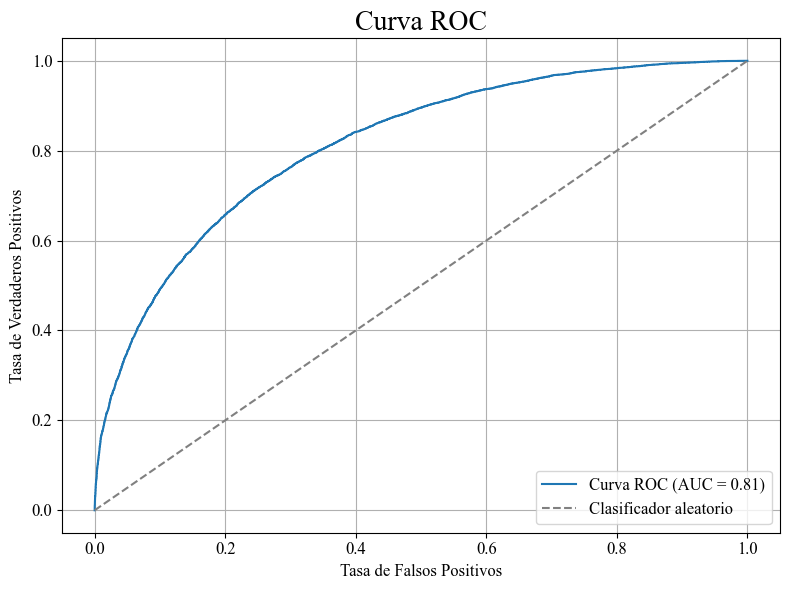


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     18141
           1       0.69      0.59      0.63     10547

    accuracy                           0.75     28688
   macro avg       0.73      0.72      0.72     28688
weighted avg       0.75      0.75      0.75     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86     42329
           1       0.79      0.67      0.72     24608

    accuracy                           0.81     66937
   macro avg       0.81      0.78      0.79     66937
weighted avg       0.81      0.81      0.81     66937



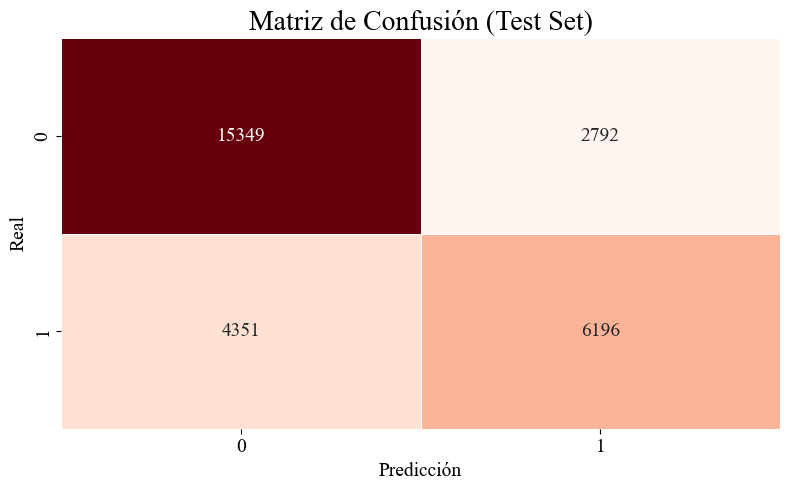

In [84]:
# XG Boost

model_xgb = xgb.XGBClassifier(n_jobs=-1)
one_to_left = st.beta(10, 1) 
params_xgb = {
    "n_estimators": st.randint(50,500),  
    "max_depth": st.randint(1, 10),    
    "learning_rate": st.uniform(0.01, 0.2), 
    "colsample_bytree": one_to_left, 
    "subsample": one_to_left,     
    "gamma": st.uniform(0, 10),
    'reg_lambda': st.uniform(0.05,10),  
    "min_child_weight": st.uniform(1,20)
}


model_xgb = xgb.XGBClassifier(n_jobs=-1,random_state=14)

y_pred_train_xgb, y_prob_train_xgb, y_pred_test_xgb, y_prob_test_xgb=run_classifier_otros(model_xgb, params_xgb, 'XG_Boost')

Los mejores parámetros son {'class_weight': 'balanced', 'learning_rate': 0.06003481042947428, 'max_depth': 6, 'n_estimators': 293, 'reg_lambda': 0.836676849552418}


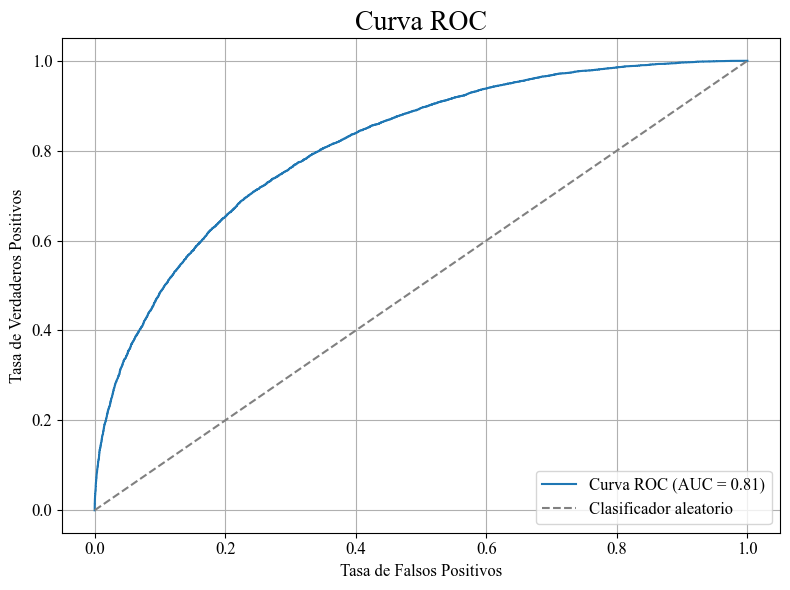


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.73      0.77     18141
           1       0.61      0.74      0.67     10547

    accuracy                           0.73     28688
   macro avg       0.72      0.73      0.72     28688
weighted avg       0.75      0.73      0.73     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.85      0.74      0.79     42329
           1       0.63      0.77      0.69     24608

    accuracy                           0.75     66937
   macro avg       0.74      0.75      0.74     66937
weighted avg       0.77      0.75      0.75     66937



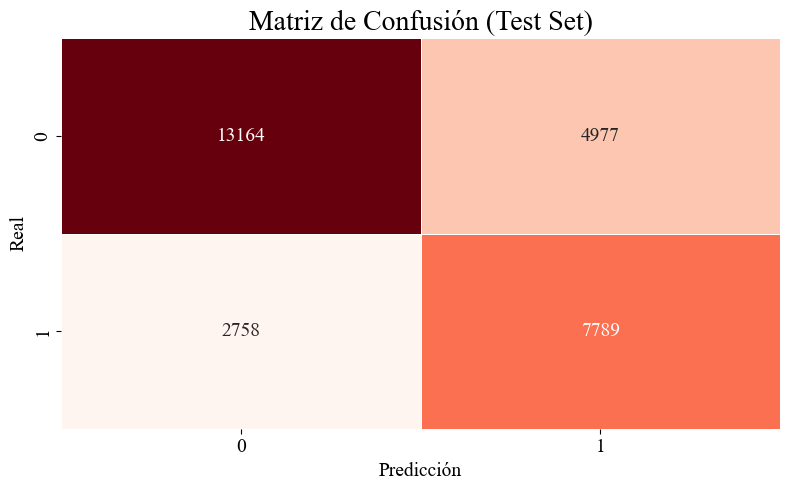

In [46]:
# Light GBM

params_lightgbm = {
    "n_estimators": st.randint(50,500),
    "learning_rate": st.uniform(0.01, 0.1),
    "max_depth": st.randint(1, 10),
    "class_weight": ["balanced"],
    'reg_lambda': st.uniform(0.05,10)

}

model_ltb = ltb.LGBMClassifier(verbose=-1)
y_pred_train_lgbm, y_prob_train_lgbm, y_pred_test_lgbm, y_prob_test_lgbm=run_classifier_otros(model_ltb, params_lightgbm, 'LightGBM')

Los mejores parámetros son {'l2_regularization': 0.8517799297970701, 'learning_rate': 0.07006071429687985, 'max_depth': 6, 'max_iter': 328, 'min_samples_leaf': 14}


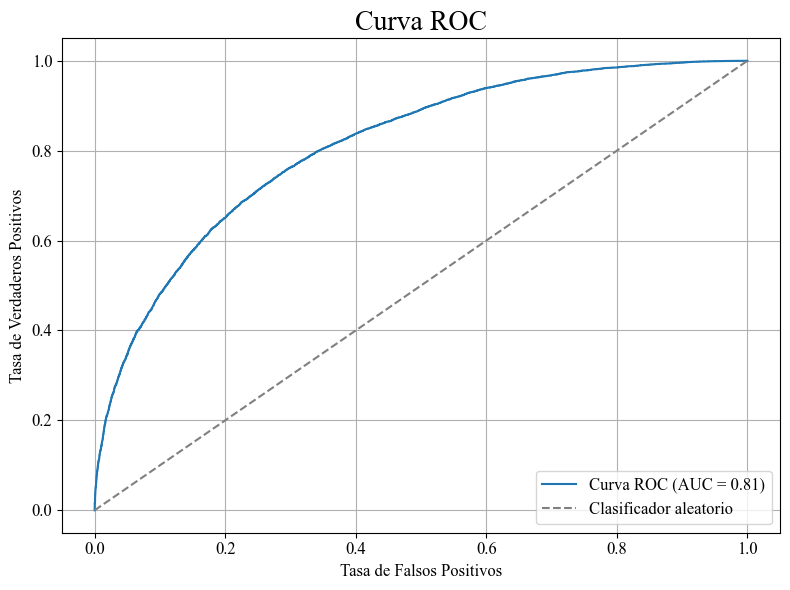


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     18141
           1       0.69      0.58      0.63     10547

    accuracy                           0.75     28688
   macro avg       0.73      0.71      0.72     28688
weighted avg       0.74      0.75      0.74     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.78      0.86      0.82     42329
           1       0.72      0.59      0.65     24608

    accuracy                           0.76     66937
   macro avg       0.75      0.73      0.74     66937
weighted avg       0.76      0.76      0.76     66937



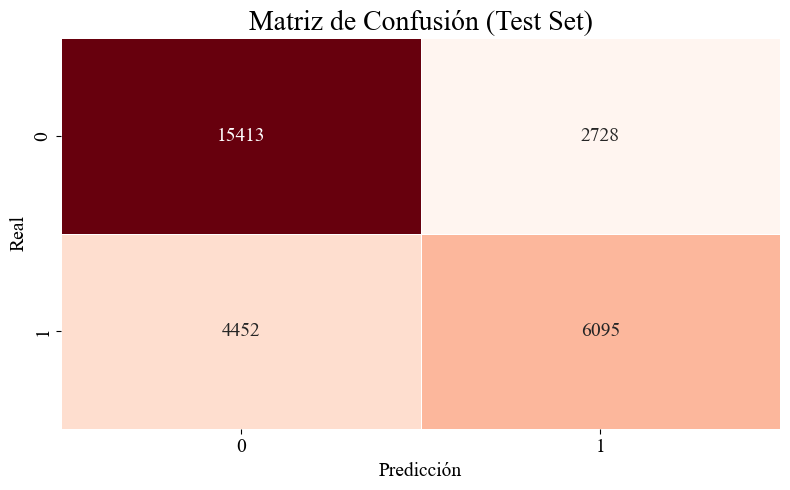

In [ ]:
# Gradient Boosting 

params_gb = param_grid = {
    "max_iter": st.randint(100, 500),
    "learning_rate": st.uniform(0.01, 0.3),
    "max_depth": st.randint(3, 10),
    "min_samples_leaf": st.randint(10, 50),
    "l2_regularization": st.uniform(0.0, 1.0)
}

model_gb = HistGradientBoostingClassifier(random_state=14)
y_pred_train_gb, y_prob_train_gb,y_pred_test_gb, y_prob_test_gb=run_classifier_otros(model_gb, params_gb, 'HistGradientBoosting')

Los mejores parámetros son {'solver': 'liblinear', 'penalty': 'l2', 'class_weight': 'balanced'}


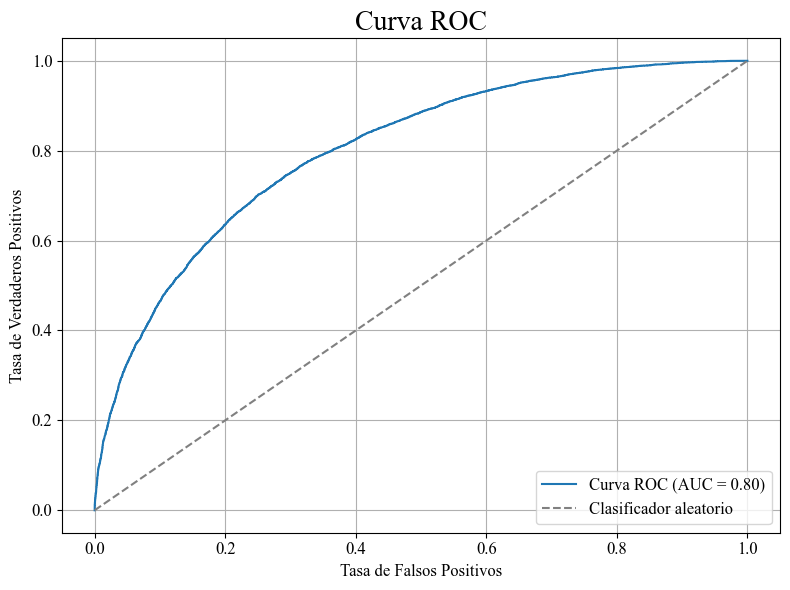


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     18141
           1       0.60      0.73      0.66     10547

    accuracy                           0.72     28688
   macro avg       0.71      0.73      0.71     28688
weighted avg       0.74      0.72      0.73     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.82      0.72      0.77     42329
           1       0.60      0.73      0.66     24608

    accuracy                           0.72     66937
   macro avg       0.71      0.72      0.71     66937
weighted avg       0.74      0.72      0.73     66937



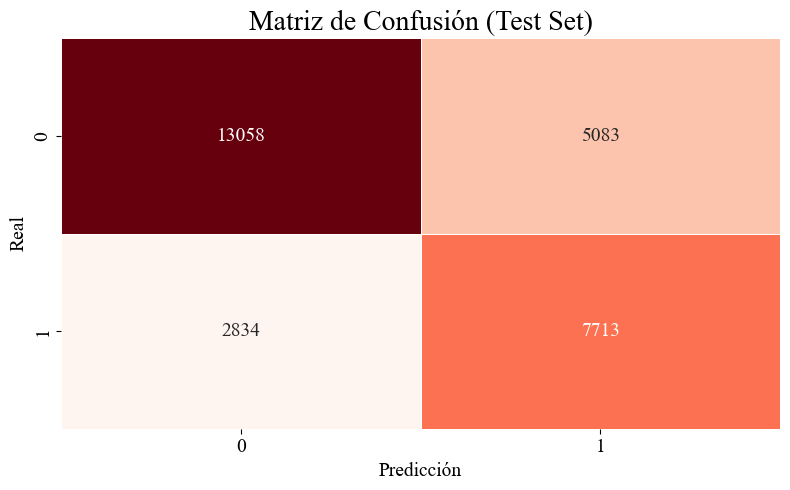

In [87]:
# Regresión Logística

lr = LogisticRegression(verbose=False,max_iter=1000)

param_grid = {'penalty': ['l2'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'class_weight': ['balanced']}


y_pred_train_lr, y_prob_train_lr,y_pred_test_lr, y_prob_test_lr=run_classifier_otros(lr, param_grid, 'Logistic Regression')

##### MLP

In [88]:
# Se instancia un modelo secuencial
model = Sequential() 


# Se añade una capa oculta con 128 neuronas, con activación sigmoidea 
model.add(Dense(128, activation='relu', input_dim=164, kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
# Se añade una capa de salida con activación sigmoidea
model.add(Dense(1, activation='sigmoid'))

In [89]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

In [90]:
model.fit(X_train_otros, y_train_otros,
            epochs=20, batch_size=16,
            validation_split=0.33)

Epoch 1/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 3s 729us/step - accuracy: 0.6786 - auc: 0.7012 - loss: 1.8461 - recall: 0.4514 - val_accuracy: 0.7247 - val_auc: 0.7749 - val_loss: 0.7247 - val_recall: 0.5593
Epoch 2/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.7075 - auc: 0.7554 - loss: 0.6827 - recall: 0.4974 - val_accuracy: 0.7277 - val_auc: 0.7863 - val_loss: 0.5765 - val_recall: 0.6124
Epoch 3/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step - accuracy: 0.7184 - auc: 0.7718 - loss: 0.5831 - recall: 0.5428 - val_accuracy: 0.7336 - val_auc: 0.7910 - val_loss: 0.5638 - val_recall: 0.4743
Epoch 4/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 639us/step - accuracy: 0.7229 - auc: 0.7748 - loss: 0.5711 - recall: 0.5457 - val_accuracy: 0.7329 - val_auc: 0.7963 - val_loss: 0.5517 - val_recall: 0.6477
Epoch 5/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step - accuracy: 0.7288 - auc: 0.7823 - loss: 0.5623 - recall: 0.5511 - val_accuracy: 0.7284 - val_auc: 0.7960 - val_loss: 0.5580 - val_recal

Se utiliza dropout con técnica de regularización

In [91]:
# Se añade una capa oculta con 128 neuronas, con activación sigmoidea 
model_dropout = Sequential()
model_dropout.add(Dense(128, activation='relu', input_dim=164, kernel_regularizer=regularizers.l1(0.001)))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model_dropout.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
model_dropout.add(Dense(1, activation='sigmoid'))


# Compilar sin la métrica F1
model_dropout.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(),tf.keras.metrics.AUC(name='auc')]
    
)

# Entrenar 
history = model_dropout.fit(
    X_train_otros, y_train_otros,
    epochs=20,
    batch_size=16,
    validation_split=0.3333
)

# Evaluar F1 luego con predicciones
y_pred = model_dropout.predict(X_test_otros)
y_pred_binary = (y_pred > 0.5).astype(int)
print(f"F1 Score: {f1_score(y_test, y_pred_binary.ravel())}")



Epoch 1/20
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 2s 711us/step - auc: 0.6460 - binary_accuracy: 0.6508 - loss: 2.1291 - recall: 0.3651 - val_auc: 0.7494 - val_binary_accuracy: 0.6992 - val_loss: 0.6228 - val_recall: 0.6366
Epoch 2/20
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step - auc: 0.7247 - binary_accuracy: 0.6851 - loss: 0.6348 - recall: 0.4865 - val_auc: 0.7641 - val_binary_accuracy: 0.6896 - val_loss: 0.6195 - val_recall: 0.7114
Epoch 3/20
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step - auc: 0.7328 - binary_accuracy: 0.6937 - loss: 0.6220 - recall: 0.4780 - val_auc: 0.7602 - val_binary_accuracy: 0.7101 - val_loss: 0.6026 - val_recall: 0.5447
Epoch 4/20
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 2s 660us/step - auc: 0.7372 - binary_accuracy: 0.6980 - loss: 0.6213 - recall: 0.4766 - val_auc: 0.7658 - val_binary_accuracy: 0.7183 - val_loss: 0.6074 - val_recall: 0.5019
Epoch 5/20
2790/2790 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - auc: 0.7377 - binary_accuracy: 0.6987 - loss: 0.6169 - recall: 0.4551 - val_au

Se utiliza early stopping

In [92]:
# Se instancia el objeto early_stopping y se define una lista de callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, restore_best_weights=True, verbose=1)
callbacks_list = [early_stopping]

In [94]:
#Se utiliza el modelo que se ha instanciado anteriormente
history_stop = model_dropout.fit(X_train_otros, y_train_otros,
            epochs=20, batch_size=16,
            validation_split=0.33,
            callbacks=callbacks_list)

Epoch 1/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step - auc: 0.7369 - binary_accuracy: 0.6993 - loss: 0.6165 - recall: 0.4709 - val_auc: 0.7647 - val_binary_accuracy: 0.7051 - val_loss: 0.5992 - val_recall: 0.6118
Epoch 2/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 684us/step - auc: 0.7412 - binary_accuracy: 0.7015 - loss: 0.6155 - recall: 0.4847 - val_auc: 0.7712 - val_binary_accuracy: 0.7184 - val_loss: 0.5922 - val_recall: 0.5416
Epoch 3/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 629us/step - auc: 0.7407 - binary_accuracy: 0.6936 - loss: 0.6187 - recall: 0.4731 - val_auc: 0.7750 - val_binary_accuracy: 0.7196 - val_loss: 0.5927 - val_recall: 0.5723
Epoch 4/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - auc: 0.7438 - binary_accuracy: 0.7024 - loss: 0.6138 - recall: 0.4881 - val_auc: 0.7724 - val_binary_accuracy: 0.7105 - val_loss: 0.5972 - val_recall: 0.6384
Epoch 5/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - auc: 0.7445 - binary_accuracy: 0.7007 - loss: 0.6157 - recall: 0.5010 - val_au

Se prueba Model CheckPoint

In [95]:
# Compilar el modelo con AUC como métrica adicional
model_dropout.compile(
    loss='binary_crossentropy',
    metrics=[metrics.BinaryAccuracy(), metrics.Recall(), metrics.AUC()],  
    optimizer='rmsprop'
)

In [96]:
# Se instancia el objeto checkpoint con el formato correcto
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

# Lista de callbacks
callbacks_list = [checkpoint]

# Entrenamiento del modelo
history = model_dropout.fit(
    X_train_otros, y_train_otros,
    epochs=20,
    batch_size=16,
    validation_split=0.33,
    callbacks=callbacks_list
)


Epoch 1/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 683us/step - auc: 0.7339 - binary_accuracy: 0.6971 - loss: 0.6133 - recall_1: 0.4758 - val_auc: 0.7691 - val_binary_accuracy: 0.7108 - val_loss: 0.5908 - val_recall_1: 0.5692
Epoch 2/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step - auc: 0.7395 - binary_accuracy: 0.6986 - loss: 0.6072 - recall_1: 0.4771 - val_auc: 0.7713 - val_binary_accuracy: 0.7188 - val_loss: 0.5816 - val_recall_1: 0.4803
Epoch 3/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step - auc: 0.7434 - binary_accuracy: 0.7063 - loss: 0.6047 - recall_1: 0.4805 - val_auc: 0.7729 - val_binary_accuracy: 0.7151 - val_loss: 0.5957 - val_recall_1: 0.5666
Epoch 4/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 655us/step - auc: 0.7423 - binary_accuracy: 0.7012 - loss: 0.6072 - recall_1: 0.4787 - val_auc: 0.7800 - val_binary_accuracy: 0.7270 - val_loss: 0.5748 - val_recall_1: 0.5391
Epoch 5/20
2803/2803 ━━━━━━━━━━━━━━━━━━━━ 2s 659us/step - auc: 0.7462 - binary_accuracy: 0.7045 - loss: 0.6017 - recall_

In [97]:
test_loss, test_accuracy, test_recall, test_auc = model_dropout.evaluate(X_test_otros, y_test_otros)
print(f"Loss: {test_loss:.4f} | Accuracy: {test_accuracy:.4f} | Recall: {test_recall:.4f} | AUC: {test_auc:.4f}")

897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - auc: 0.7802 - binary_accuracy: 0.7217 - loss: 0.5787 - recall_1: 0.4741
Loss: 0.5820 | Accuracy: 0.7177 | Recall: 0.4653 | AUC: 0.7742


In [98]:
# Se defune y prob para luego poder comparar AUC con otros modelos
y_prob_test_mlp = model_dropout.predict(X_test_otros).ravel()  

897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


### 9. Comparación de AUC

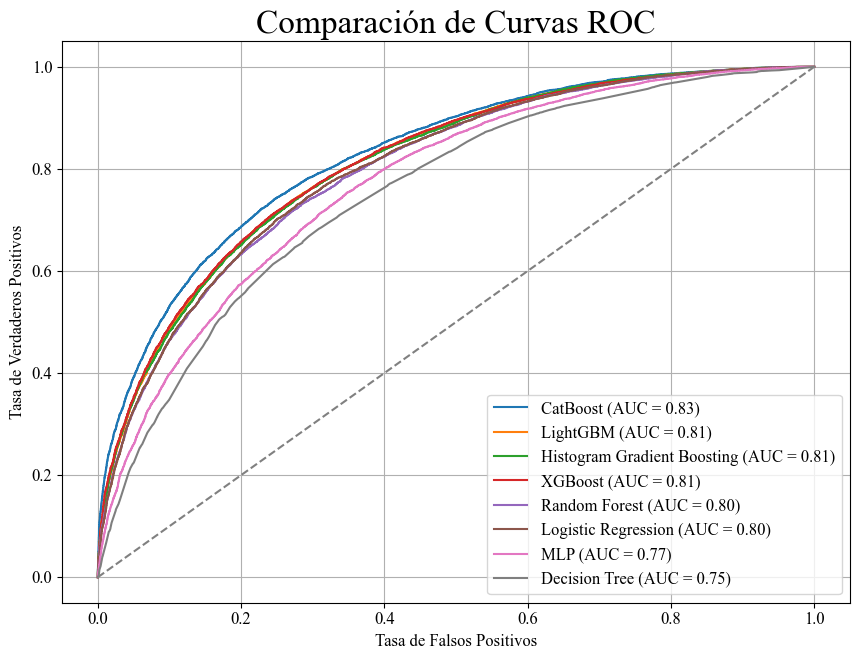

In [112]:
# Configurar fuente global en Times New Roman
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 20  

# Diccionario de nombres y probabilidades de cada modelo
model_probs = {
    'CatBoost': y_prob_test_cat,
    'LightGBM': y_prob_test_lgbm,
    'Histogram Gradient Boosting': y_prob_test_gb,
    'XGBoost': y_prob_test_xgb,
    'Random Forest': y_prob_test_rf,
    'Logistic Regression': y_prob_test_lr,
    'MLP': y_prob_test_mlp,
    'Decision Tree': y_prob_test_dt,
}

plt.figure(figsize=(9,7))

for name, probs in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel('Tasa de Falsos Positivos', fontsize=12, fontname='Times New Roman')
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=12, fontname='Times New Roman')
plt.title('Comparación de Curvas ROC')
plt.legend(loc='lower right', fontsize=12)
plt.tick_params(axis='both', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### 10. Entrenamiento de CatBoost con riesgo binarizado con nueva variable (Altísimo o Alto = 1, resto = 0)

Los mejores parámetros son {'random_strength': 1.0770311085781668, 'n_estimators': 374, 'max_depth': 8, 'learning_rate': 0.10312313809306936, 'l2_leaf_reg': 12, 'bagging_temperature': 5.598920042252644}
Tiempo de entrenamiento: 44.28 segundos


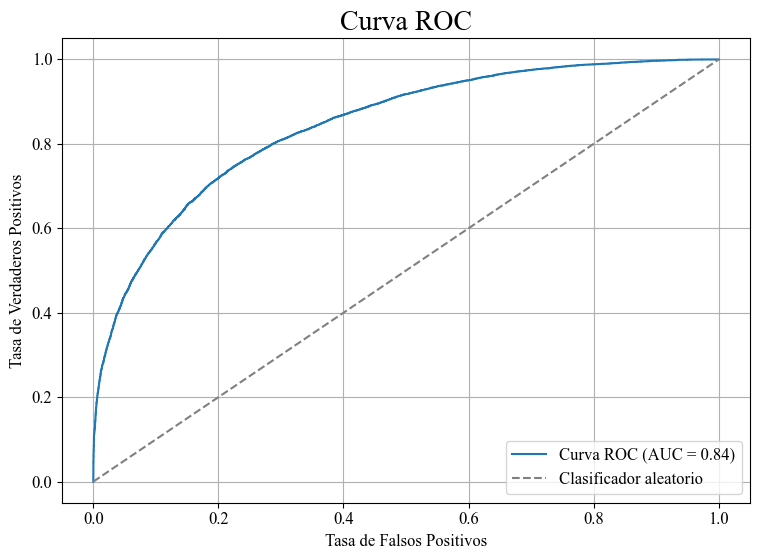


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.84      0.77      0.80     18141
           1       0.65      0.75      0.70     10547

    accuracy                           0.76     28688
   macro avg       0.75      0.76      0.75     28688
weighted avg       0.77      0.76      0.76     28688


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.89      0.81      0.85     42329
           1       0.72      0.82      0.77     24608

    accuracy                           0.82     66937
   macro avg       0.80      0.82      0.81     66937
weighted avg       0.83      0.82      0.82     66937



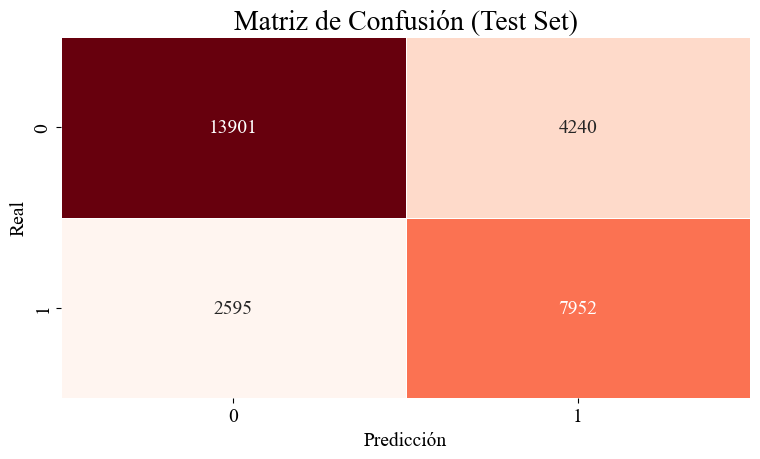

In [100]:
# Se copia df para luego agregar nueva variable
df_cb=df.copy()

# Se define variable de interaccion entre mes y barrio
df_cb['mes_barrio'] = df_cb['mes'] + '_' + df_cb['barrio']

# Se eliminan mes y barrio individualmente
df_cb.drop(columns=['mes','barrio'],inplace=True)

# Se define variable objetivo
df_cb['eva_riesgo_2'] = df_cb['eva_riesgo_2'].astype(int)
y_cb = df_cb['eva_riesgo_2']

# Se define variable explicativa
X_cb = df_cb.drop(["eva_riesgo_2",'eva_riesgo','eva_riesgo_3'], axis = 1)

#Se dividen en training y testing 70/30
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, stratify=y_cb, random_state=14,test_size=0.3)

# Separar columnas numéricas y categóricas
num_cols = X_train_cb.select_dtypes(include='number').columns
cat_cols = X_train_cb.select_dtypes(exclude='number').columns

# Crear y ajustar el scaler solo con columnas numéricas
scaler = StandardScaler()
scaler.fit(X_train_cb[num_cols])

# Transformar X_train y X_test solo en columnas numéricas
X_train_scaled_cb = pd.DataFrame(scaler.transform(X_train_cb[num_cols]), columns=num_cols, index=X_train_cb.index)
X_test_scaled_cb = pd.DataFrame(scaler.transform(X_test_cb[num_cols]), columns=num_cols, index=X_test_cb.index)

# Concatenar columnas numéricas escaladas con categóricas originales
X_train_cb = pd.concat([X_train_scaled_cb, X_train_cb[cat_cols]], axis=1)
X_test_cb = pd.concat([X_test_scaled_cb, X_test_cb[cat_cols]], axis=1)

# Catboost

param_grid = {
    "n_estimators": st.randint(100, 500),
    "learning_rate": st.uniform(0.01, 0.3),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 30),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}


# Se agrega class weights para darle mas peso a la clase minoritaria
class_counts = Counter(y_train_cb)
total = sum(class_counts.values())
n_classes = len(class_counts)
class_weights = [total / (n_classes * class_counts[i]) for i in sorted(class_counts)]

catboost = CatBoostClassifier(
    loss_function='Logloss',
    verbose=False,
    subsample=0.8,
    random_state=34,
    class_weights=class_weights
)

model_2,y_pred_train_cat_2, y_prob_train_cat_2, y_pred_test_cat_2, y_prob_test_cat_2 = run_classifier_catboost(X_train_cb, X_test_cb, y_train_cb, y_test_cb, catboost, param_grid, "Catboost")


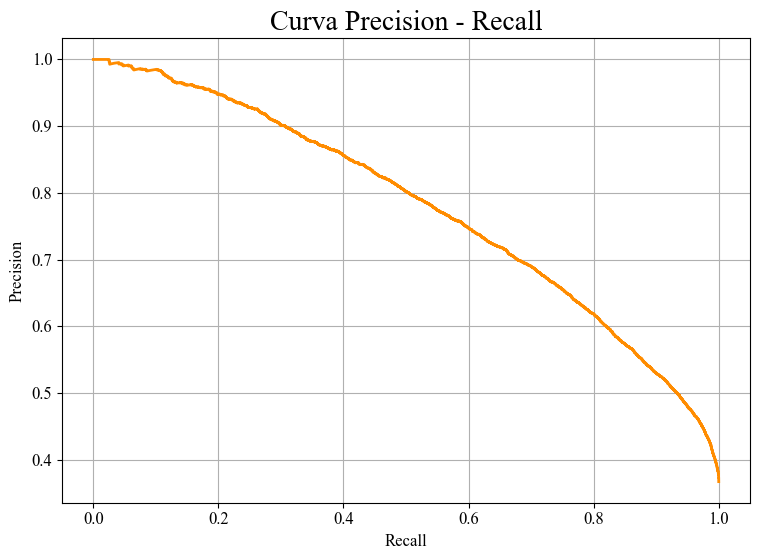

In [101]:
# Calcular los valores de precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test_cb, y_prob_test_cat_2)

# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall', fontsize=12, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=12, fontname='Times New Roman')
plt.title('Curva Precision - Recall', fontsize=20, fontname='Times New Roman')

# Cambiar tamaño de fuente de los números en los ejes
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.70      0.77     18141
           1       0.61      0.81      0.70     10547

    accuracy                           0.74     28688
   macro avg       0.74      0.75      0.74     28688
weighted avg       0.77      0.74      0.75     28688


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     42329
           1       0.67      0.87      0.76     24608

    accuracy                           0.80     66937
   macro avg       0.79      0.81      0.79     66937
weighted avg       0.82      0.80      0.80     66937



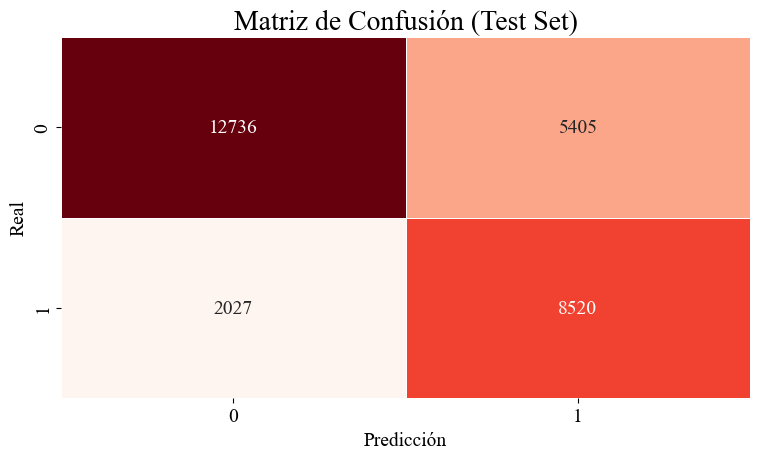

In [102]:
# Hacer nuevas predicciones seteando el umbral
y_pred_optimal_test_2 = (y_prob_test_cat_2 >= 0.44).astype(int)
y_pred_optimal_train_2 = (y_prob_train_cat_2 >= 0.44).astype(int)

# Reporte de Clasificación (Test Set)
print("\nReporte de Clasificación (Test Set):")
print(classification_report(y_test_cb, y_pred_optimal_test_2))
# Reporte de Clasificación (Train Set)
print("\nReporte de Clasificación (Test Set):")
print(classification_report(y_train_cb, y_pred_optimal_train_2))

# Matriz de confusión (Test Set) para el nuevo umbral
cm = confusion_matrix(y_test_cb, y_pred_optimal_test_2)

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    cm,
    annot=True,
    cbar=False,
    fmt="d",
    linewidths=0.5,
    cmap="Reds",
    ax=ax,
    annot_kws={"size": 14, "fontname": "Times New Roman"}  
)


ax.set_title("Matriz de Confusión (Test Set)", fontsize=20, fontname="Times New Roman")
ax.set_xlabel("Predicción", fontsize=14, fontname="Times New Roman")
ax.set_ylabel("Real", fontsize=14, fontname="Times New Roman")
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname="Times New Roman")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, fontname="Times New Roman")

plt.tight_layout()
plt.show()


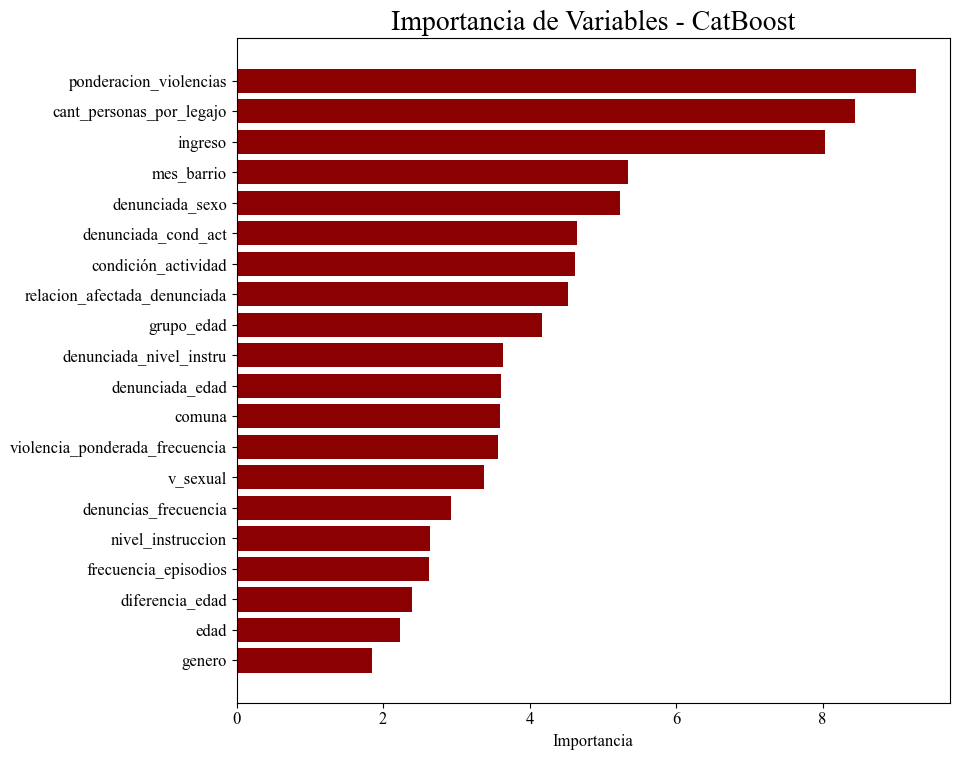

In [103]:
# Obtener la importancia directamente del modelo
feature_importances_2 = model_2.get_feature_importance()
feature_names_2 = model_2.feature_names_

# Crear DataFrame ordenado
df_importance_2 = pd.DataFrame({
    'feature': feature_names_2,
    'importance': feature_importances_2
}).sort_values(by='importance', ascending=False)

df_importance_plot_2 = df_importance_2.head(20)

# Graficar
plt.figure(figsize=(10, 8))
plt.barh(df_importance_plot_2['feature'], df_importance_plot_2['importance'], color='darkred')  
plt.gca().invert_yaxis()
plt.xlabel('Importancia', fontsize=12, fontname='Times New Roman')
plt.title('Importancia de Variables - CatBoost', fontsize=20, fontname='Times New Roman')
plt.xticks(fontsize=12, fontname='Times New Roman')
plt.yticks(fontsize=12, fontname='Times New Roman')
plt.tight_layout()
plt.show()

### Seccion Adicional

In [104]:
def procesar(denuncias_2020, 
             denuncias_2021, denuncias_2022, denuncias_2023, 
             denuncias_caract_2022, denuncias_caract_2023):
    

    """
    Procesa CSV con las denuncias de cada año.

    Parámetros:
    - denuncias_2017 a denuncias_2023: DataFrames con las denuncias de cada año.
    - denuncias_caract_2022, denuncias_caract_2023: DataFrames con características adicionales de los años 2022 y 2023

    Retorna un DataFrame unificado con las denuncias de cada año y las columnas en común
    """

    # Se crea una lista de dataframes
    dataframes = [denuncias_2020, 
                  denuncias_2021, denuncias_2022, denuncias_2023, 
                  denuncias_caract_2022, denuncias_caract_2023]
    
    for df in dataframes:
        df.columns = [col.lower() for col in df.columns]

    # Se genera columna de año con el formato correcto
    denuncias_2023['año'] = '2023'
    denuncias_2022['año'] = '2022'
    denuncias_2021['año'] = '2021'
    denuncias_2020['año'] = '2020'

        
    # Seleccionar columnas de las bases de características
    denuncias_caract_2023 = denuncias_caract_2023[['id_datos_abiertos_legajo', 'ingreso', 'denuncia_tercera']]
    denuncias_caract_2022 = denuncias_caract_2022[['id_datos_abiertos_legajo', 'ingreso', 'denuncia_tercera']]
    
    # Merge con las tablas de características
    denuncias_2023 = denuncias_2023.merge(denuncias_caract_2023, on='id_datos_abiertos_legajo', how='left')
    denuncias_2022 = denuncias_2022.merge(denuncias_caract_2022, on='id_datos_abiertos_legajo', how='left')

    # Paso 3: Renombrar las columnas para que coincidan entre las bases de datos
    nuevos_nombres = {
        'viol_ambient': 'v_ambiental',
        'viol_fisica': 'v_fisica',
        'viol_econ': 'v_economica',
        'viol_psicol': 'v_psicologica',
        'viol_sexual': 'v_sexual',
        'viol_simb': 'v_simbolica',
        'viol_social': 'v_social',
        'legajo_tercera': 'denuncia_tercera'
    }
    
    nuevos_nombres2 = {
        'v_ambient': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psicol': 'v_psicologica',
        'v_sexual': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_social': 'v_social',
        'denunciada_nivel instru': 'denunciada_nivel_instru',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres3 = {
        'v_amb': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psic': 'v_psicologica',
        'v_sex': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_soc': 'v_social',
        'evaluacion_riesgo': 'eva_riesgo',
        'condicion_actividad': 'condición_actividad',
        'sexo_genero': 'genero',
        'denunciada_cond_lab': 'denunciada_cond_act',
        'nivel_instru': 'nivel_instruccion',
        'condición_laboral': 'condición_actividad',
        'denunciada_sexo_genero': 'denunciada_sexo',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres4 = {
        'v_amb': 'v_ambiental',
        'v_fisica': 'v_fisica',
        'v_econ': 'v_economica',
        'v_psic': 'v_psicologica',
        'v_sex': 'v_sexual',
        'v_simb': 'v_simbolica',
        'v_soc': 'v_social',
        'evaluacion_riesgo': 'eva_riesgo',
        'condicion_actividad': 'condición_actividad',
        'sexo_genero': 'genero',
        'denunciada_cond_lab': 'denunciada_cond_act',
        'nivel_instru': 'nivel_instruccion',
        'condición_laboral': 'condición_actividad',
        'denunciada_sexo_genero': 'denunciada_sexo',
        'sexo': 'genero',
        'leg_tercera': 'denuncia_tercera'
    }

    nuevos_nombres5 = {'leg_tercera': 'denuncia_tercera',
                       'v_económica':'v_economica'}

    # Renombrar las columnas en cada DataFrame
    denuncias_2020 = denuncias_2020.rename(columns=nuevos_nombres3)
    denuncias_2021 = denuncias_2021.rename(columns=nuevos_nombres)
    denuncias_2023 = denuncias_2023.rename(columns=nuevos_nombres2)
    denuncias_2022 = denuncias_2022.rename(columns=nuevos_nombres5)

    # Seleccionar columnas comunes entre los DataFrames
    columnas_comunes = [
        'año', 'barrio', 'categoria_ocupacional', 'categoria_ocupacional_detalle', 'cohabitan', 
        'comuna', 'condición_actividad', 'denunciada_cond_act', 'denunciada_edad', 'denunciada_nivel_instru', 
        'denunciada_sexo', 'domicilio_provincia', 'edad', 'eva_riesgo', 'frecuencia_episodios', 'genero', 
        'grupo_edad', 'id_datos_abiertos_legajo', 'id_datos_abiertos_persona', 'ingreso', 'localidad_otras_provincias', 
        'mes', 'nacionalidad', 'nivel_instruccion', 'relacion_afectada_denunciada', 'v_ambiental', 'v_economica', 
        'v_fisica', 'v_psicologica', 'v_sexual', 'v_simbolica', 'v_social', 'denuncia_tercera'
    ]
    
    # Filtrar las columnas comunes en cada DataFrame

    denuncias_2020 = denuncias_2020[columnas_comunes]
    denuncias_2021 = denuncias_2021[columnas_comunes]
    denuncias_2022 = denuncias_2022[columnas_comunes]
    denuncias_2023 = denuncias_2023[columnas_comunes]

    
    # Concatenar todos los DataFrames
    dataframes = [denuncias_2020, denuncias_2021, denuncias_2022, denuncias_2023]

    df = pd.concat(dataframes, ignore_index=True)

    return df


In [105]:
df_2020_2023 = procesar(denuncias_2020, denuncias_2021, denuncias_2022, denuncias_2023,denuncias_caract_2022, denuncias_caract_2023)

In [106]:
#  Convierte nombres de columnas a minúsculas y reemplaza valores nulos comunes por np.nan
df_2020_2023=estandarizar_nombres_y_nulos(df_2020_2023)

#  Rellena valores nulos en la columna 'edad' con un numero fuera de rango,  convierte a entero y reemplaza esos valores con la media de edades válidas
df_2020_2023=limpiar_y_transformar_edad(df_2020_2023)

#  Estandariza las categorías de la columna 'ingreso', agrupando entradas similares bajo categorías comunes.
df_2020_2023=estandarizar_ingreso(df_2020_2023)

#  Asigna un grupo etario a partir de la columna 'edad' y crea la columna 'grupo_edad', si bien ya existe se asegura que esten bien asignadas.    
df_2020_2023=asignar_grupo_edad(df_2020_2023)

# Rellena los valores nulos en `nivel_instruccion` con la moda correspondiente de su grupo 'grupo edad'
df_2020_2023 = rellenar_nulos_por_moda(df_2020_2023, 'nivel_instruccion','grupo_edad')

# Rellenar denunciada_nivel_instru 
df_2020_2023 = rellenar_nulos_por_moda(df_2020_2023, 'denunciada_nivel_instru', 'denunciada_edad')

# Rellena los valores nulos en `condición_actividad` con la moda correspondiente de su grupo 'grupo edad'
df_2020_2023 = rellenar_nulos_por_moda(df_2020_2023, 'condición_actividad', 'grupo_edad')

# Rellenar denunciada_cond_act
df_2020_2023 = rellenar_nulos_por_moda(df_2020_2023, 'denunciada_cond_act','denunciada_edad')

# Corrige y estandariza valores de columnas categóricas según reglas definidas
df_2020_2023= estandarizar_categorias(df_2020_2023)

# Se mantienen los casos en los que hay datos sobre la convivencia, dado que el porcentaje de casos que no hay datos es bajo
df_2020_2023 = df_2020_2023[df_2020_2023['cohabitan'] != 'S/D']

# Se mantienen los casos en los que hay datos sobre la variable objetivo
df_2020_2023 = df_2020_2023[df_2020_2023['eva_riesgo'].notnull()]

# Para las columnas con una pequeño porcentaje de valores nulos, se rellena con la moda
for col in df_2020_2023.columns:
    if df_2020_2023[col].isnull().any():
        moda = df_2020_2023[col].mode()[0]
        df_2020_2023[col] = df_2020_2023[col].fillna(moda)



In [107]:
# Crear flag para legajos que tengan al menos una persona menor de 18
df_2020_2023 = flag_menores(df_2020_2023)

# Crear flag para legajos que tengan al menos una persona mayor de 60
df_2020_2023 = flag_mayores(df_2020_2023)

# Crear flag para legajos que tengan personas del género dado entre 18 y 60 años
df_2020_2023 = flag_mayores_por_genero(df_2020_2023, 'MASCULINO', 'denuncia_con_varon_mayor')
df_2020_2023 = flag_mayores_por_genero(df_2020_2023, 'FEMENINO', 'denuncia_con_mujer_mayor')

# Crear flag para legajos que tengan al menos una persona de genero transgenero u otros
otro_sexo_mask = (df_2020_2023['genero'].isin(['MUJER TRANS / TRAVESTI', 'VARON TRANS', 'OTROS']))
otro_sexo_ids = df_2020_2023[otro_sexo_mask]['id_datos_abiertos_legajo'].unique()
df_2020_2023['denuncia_otro_sexo'] = df_2020_2023['id_datos_abiertos_legajo'].isin(otro_sexo_ids).astype(int)

# Convertir columnas de 0/1 a "SI"/"NO"    
df_2020_2023 = convertir_flag_a_si_no(df_2020_2023, ['flag_menor', 'flag_mayor','denuncia_con_varon_mayor', 'denuncia_con_mujer_mayor','denuncia_otro_sexo'])

# Crear la columna cant_personas_por_legajo
df_2020_2023['cant_personas_por_legajo'] = df_2020_2023.groupby('id_datos_abiertos_legajo')['id_datos_abiertos_legajo'].transform('count')

# Asigna valores numéricos a partir del grupo de edad para facilitar cálculos y calcula diferencia de edad
df_2020_2023 = asignar_rangos_edad(df_2020_2023)

# Asigna valores numéricos a categorías de frecuencia de episodios
df_2020_2023 = codificar_frecuencia_episodios(df_2020_2023)

# Genera variable objetivo binaria
df_2020_2023['eva_riesgo_2'] = df_2020_2023['eva_riesgo'].isin(['ALTISIMO', 'ALTO']).astype(int)

df_2020_2023['eva_riesgo_3'] = df_2020_2023['eva_riesgo'].isin(['ALTISIMO']).astype(int)

# Entrena un modelo de regresión logística para calcular coeficientes de variables de violencia, luego asigna un ponderador basado en la importancia de cada tipo y calcula la ponderación total por fila.
df_2020_2023=calcular_ponderacion_violencias(df_2020_2023)

# Calcular violencia ponderada por frecuencia
df_2020_2023['violencia_ponderada_frecuencia'] = df_2020_2023['ponderacion_violencias'] * df_2020_2023['frecuencia_codificada']
   
# Calcular frecuencia por cantidad de persona por legajo
df_2020_2023['denuncias_frecuencia'] = df_2020_2023['frecuencia_codificada'] * df_2020_2023['cant_personas_por_legajo']

df_2020_2023['cantidad_violencias'] = df_2020_2023[violencia_vars].apply(contar_violencias, axis=1)

# Multiplicar la cantidad de violencias sufridas por la frecuencia codificada
df_2020_2023['violencia_frecuencia'] = df_2020_2023['cantidad_violencias'] * df_2020_2023['frecuencia_codificada']

# Convierte los niveles de instrucción de denunciada y víctima a variables ordinales, y genera una variable que representa la diferencia educativa entre ellas.
df_2020_2023 = crear_variables_educacion_ordinal(df_2020_2023)

# Se define variable de interaccion entre mes y barrio
df_2020_2023['mes_barrio'] = df_2020_2023['mes'] + '_' + df_2020_2023['barrio']

# Se eliminan mes y barrio individualmente
df_2020_2023.drop(columns=['mes','barrio'],inplace=True)


Tabla de ponderadores por tipo de violencia:
  Tipo de Violencia  Coeficiente  Ponderador
0          v_sexual     1.520365           7
1          v_fisica     0.689260           6
2          v_social     0.631709           5
3     v_psicologica     0.314367           4
4       v_ambiental     0.302209           3
5       v_simbolica     0.230598           2
6       v_economica     0.080645           1


In [108]:
#Se eliminan variables no necearias
df_2020_2023.drop(columns=['id_datos_abiertos_legajo', 'id_datos_abiertos_persona','localidad_otras_provincias','año','edad_inicio_rango','denunciada_edad_inicio_rango','categoria_ocupacional','categoria_ocupacional_detalle','flag_mayor','denuncia_otro_sexo','frecuencia_codificada'],inplace=True)

In [109]:
# Define variable objetivo
y_2020_2023 = df_2020_2023['eva_riesgo_2']

# Define variables explicativas

X_2020_2023 = df_2020_2023.drop(["eva_riesgo_2",'eva_riesgo','eva_riesgo_3'], axis = 1)

#Se dividen en training y testing 70/30
X_train_2020_2023, X_test_2020_2023, y_train_2020_2023, y_test_2020_2023 = train_test_split(X_2020_2023, y_2020_2023, stratify=y_2020_2023, random_state=14,test_size=0.3)

# Separar columnas numéricas y categóricas
num_cols = X_train_2020_2023.select_dtypes(include='number').columns
cat_cols = X_train_2020_2023.select_dtypes(exclude='number').columns

# Crear y ajustar el scaler solo con columnas numéricas
scaler = StandardScaler()
scaler.fit(X_train_2020_2023[num_cols])

# Transformar X_train y X_test solo en columnas numéricas
X_train_scaled_2020_2023 = pd.DataFrame(scaler.transform(X_train_2020_2023[num_cols]), columns=num_cols, index=X_train_2020_2023.index)
X_test_scaled_2020_2023= pd.DataFrame(scaler.transform(X_test_2020_2023[num_cols]), columns=num_cols, index=X_test_2020_2023.index)

# Concatenar columnas numéricas escaladas con categóricas originales
X_train_2020_2023 = pd.concat([X_train_scaled_2020_2023, X_train_2020_2023[cat_cols]], axis=1)
X_test_2020_2023 = pd.concat([X_test_scaled_2020_2023, X_test_2020_2023[cat_cols]], axis=1)

Los mejores parámetros son {'random_strength': 0.4326639934454728, 'n_estimators': 219, 'max_depth': 7, 'learning_rate': 0.04895372416910727, 'l2_leaf_reg': 17, 'bagging_temperature': 0.07417066052366339}
Tiempo de entrenamiento: 13.67 segundos


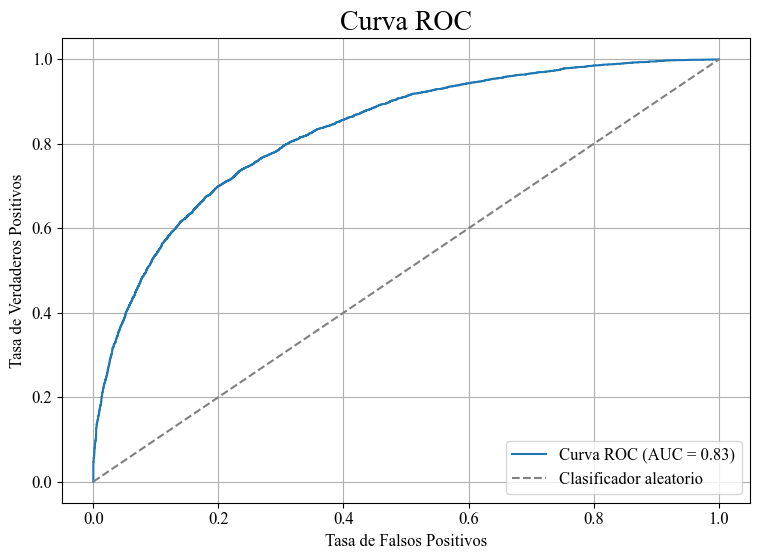


Reporte de Clasificación (Test Set):
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      9772
           1       0.73      0.56      0.64      5161

    accuracy                           0.78     14933
   macro avg       0.76      0.73      0.74     14933
weighted avg       0.77      0.78      0.77     14933


Reporte de Clasificación (Train Set):
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     22801
           1       0.80      0.64      0.71     12041

    accuracy                           0.82     34842
   macro avg       0.81      0.78      0.79     34842
weighted avg       0.82      0.82      0.81     34842



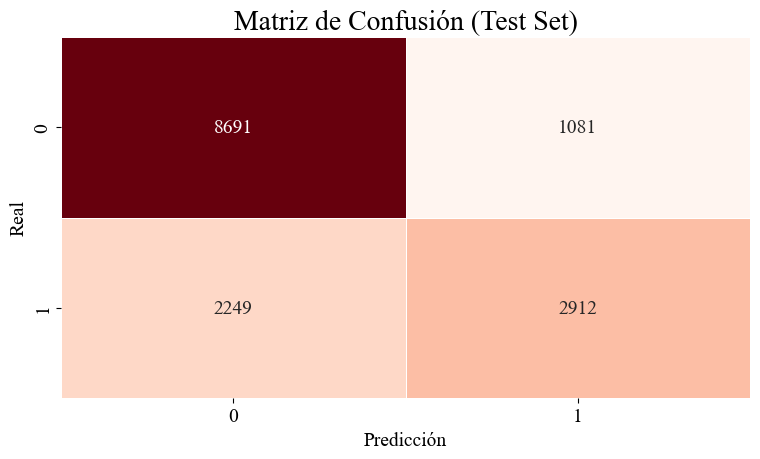

In [ ]:
# Catboost

param_grid = {
    "n_estimators": st.randint(100, 500),
    "learning_rate": st.uniform(0.01, 0.3),
    "max_depth": st.randint(1, 12),
    "l2_leaf_reg": st.randint(5, 30),
    "random_strength": st.uniform(0, 2),
    "bagging_temperature": st.uniform(0, 6)
}



catboost = CatBoostClassifier(
    loss_function='Logloss',
    verbose=False,
    subsample=0.8,
    random_state=34
)

model_2020_2023,y_pred_optimal_train_2020_2023, y_prob_train_2020_2023, y_pred_optimal_test_2020_2023, y_prob_test_2020_2023 = run_classifier_catboost(X_train_2020_2023, X_test_2020_2023, y_train_2020_2023, y_test_2020_2023, catboost, param_grid, "Catboost")

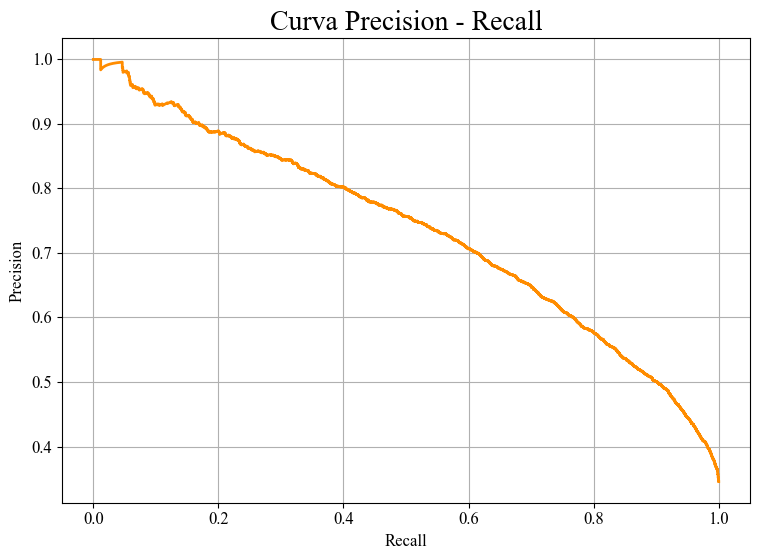

In [111]:
# Calcular los valores de precision, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test_2020_2023, y_prob_test_2020_2023)


# Graficar la curva
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2)
plt.xlabel('Recall', fontsize=12, fontname='Times New Roman')
plt.ylabel('Precision', fontsize=12, fontname='Times New Roman')
plt.title('Curva Precision - Recall', fontsize=20, fontname='Times New Roman')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Como se puede observar, aplicar el modelo solo a estos años no obtuvo una mejor performance que utilizando la totalidad de años disponibles (2020 a 2023)

## Conclusión

El modelo CatBoost se destacó como la mejor alternativa para predecir el riesgo en denuncias de violencia doméstica, alcanzando un AUC de 0.84 y un recall del 0.81 al calibrar el umbral de decisión en 0.44. Este ajuste permitió mejorar la sensibilidad del modelo, priorizando la detección de los casos más críticos, sin comprometer excesivamente la precisión. El análisis de importancia de variables reveló que factores como el tipo de ingreso de la denuncia, la combinación de tipos de violencia, el contexto territorial y temporal, y la estructura familiar son altamente influyentes en la evaluación del riesgo. Aunque se evaluó el uso de SMOTE para balancear clases, no se observaron mejoras significativas. En conjunto, el modelo entrenado muestra un buen desempeño y robustez, validando su uso como herramienta predictiva en contextos reales